In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from seaborn import heatmap, diverging_palette
import matplotlib.colors
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import category_encoders as enc
from sklearn.model_selection import train_test_split
from copy import deepcopy
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost
from sklearn.preprocessing import LabelEncoder

## 1. Data Analyze and preproccessing
Home sales prices and characteristics for Seattle and King County, WA (May 2014 - 2015) and its corresponding shape file with the zip code zones for King County.

Observations = 21,613

- id =	Identification\
- date =	Date sold\
- price =	Sale price\
- bedrooms =	Number of bedrooms\
- bathrooms =	Number of bathrooms\
- sqft_liv =	Size of living area in square feet\
- sqft_lot =	Size of the lot in square feet\
- floors = Number of floors\
- waterfront =	‘1’ if the property has a waterfront, ‘0’ if not.\
- view =	An index from 0 to 4 of how good the view of the property was\
- condition =	Condition of the house, ranked from 1 to 5\
- grade =	Classification by construction quality which refers to the types of materials used and the quality of workmanship. Buildings of better quality (higher grade) cost more to build per unit of measure and command higher value. Additional information in: KingCounty
- sqft_above =	Square feet above ground\
- sqft_basmt =	Square feet below ground\
- yr_built =	Year built\
- yr_renov =	Year renovated. ‘0’ if never renovated\
- zipcode =	5 digit zip code\
- lat =	Latitude\
- long =	Longitude\
- squft_liv15 =	Average size of interior housing living space for the closest 15 houses, in square feet\
- squft_lot15 =	Average size of land lots for the closest 15 houses, in square feet


`goal` of this project is `predicting price` of a house by analyzing its other feature

In [17]:
class PreProcess:
    def __init__(self, data: pd.DataFrame):
        self.primitive = deepcopy(data)
        self.data = data

    def reset_data(self):
        self.data = self.primitive
        return self.data

    def get_missing(self):
        nan_values = pd.DataFrame()
        nan_values['missing_count'] = self.data.isna().sum()
        nan_values['missing_percentage'] = nan_values['missing_count'] / len(self.data)

        return nan_values.round(4)

    def fill_nan(self):
        self.data.fillna(self.data.median(), inplace=True)
    
    def drop_unused(self, to_drop: list):
        self.data.drop(to_drop, axis = 1, inplace = True)


    def get_neg_cols(self):
        numeric_cols = self.data.select_dtypes(include='number').min()
        neg_min = numeric_cols[numeric_cols < 0].index.tolist()
        return neg_min
        

    def normalize(self, exclude_cols):
        numeric = self.data.select_dtypes(include='number')
        self.data[numeric.columns] = MinMaxScaler().fit_transform(numeric)
        self.data[exclude_cols] = numeric[exclude_cols]

    def encode_categories(self):
        to_encode = self.data.select_dtypes(include=['category', 'object'])
        self.data[to_encode.columns] = to_encode.apply(LabelEncoder().fit_transform)

## 1.1 Data info
as we see there is 3 categorical features

In [18]:
data = pd.read_csv('house_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      21613 non-null  int64  
 1   Unnamed: 0.1    21613 non-null  int64  
 2   Unnamed: 0.1.1  21613 non-null  int64  
 3   id              21613 non-null  int64  
 4   date            21613 non-null  object 
 5   price           21613 non-null  float64
 6   bedrooms        21613 non-null  int64  
 7   bathrooms       21613 non-null  float64
 8   sqft_living     18528 non-null  float64
 9   sqft_lot        21613 non-null  int64  
 10  floors          18530 non-null  float64
 11  waterfront      21613 non-null  int64  
 12  view            21613 non-null  int64  
 13  condition       21613 non-null  int64  
 14  grade           21613 non-null  int64  
 15  sqft_above      21613 non-null  int64  
 16  sqft_basement   21184 non-null  float64
 17  yr_built        18531 non-null 

## 1.2 Missing data
there is about 3000 rows with missing values, so droping them(14% of data!) is not a good idea!

In [19]:
pre = PreProcess(data)
pre.get_missing()

,missing_count,missing_percentage
Unnamed: 0,0,0.0000
Unnamed: 0.1,0,0.0000
Unnamed: 0.1.1,0,0.0000
id,0,0.0000
date,0,0.0000
price,0,0.0000
bedrooms,0,0.0000
bathrooms,0,0.0000
sqft_living,3085,0.1427
sqft_lot,0,0.0000


In [20]:
data.describe()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,house_age
count,21613.00000,21613.00000,21613.00000,2.161300e+04,2.161300e+04,21613.000000,21613.000000,18528.000000,2.161300e+04,18530.000000,...,21613.000000,21184.000000,18531.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,10806.00000,10806.00000,10806.00000,4.580302e+09,5.401822e+05,3.367464,2.111900,2077.569031,1.510697e+04,1.492903,...,1788.390691,292.121082,1970.896714,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652,50.994864
std,6239.28002,6239.28002,6239.28002,2.876566e+09,3.673622e+05,0.943028,0.780697,953.971679,4.142051e+04,0.538562,...,828.090978,442.637777,29.406420,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631,29.373411
min,0.00000,0.00000,0.00000,1.000102e+06,7.500000e+04,-5.000000,-5.000000,-33323.000000,5.200000e+02,1.000000,...,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000,7.000000
25%,5403.00000,5403.00000,5403.00000,2.123049e+09,3.219500e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,...,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000,25.000000
50%,10806.00000,10806.00000,10806.00000,3.904930e+09,4.500000e+05,3.000000,2.250000,1920.000000,7.618000e+03,1.500000,...,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000,47.000000
75%,16209.00000,16209.00000,16209.00000,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,...,2210.000000,560.000000,1996.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000,71.000000
max,21612.00000,21612.00000,21612.00000,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,...,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000,122.000000


## 1.3 Remove unneccery data
as we see first three columns are completely useless, so we drop them.

plus, we do not need house IDs, it is unique and does not provide analyzable information

In [21]:
pre.drop_unused(['Unnamed: 0.1', 'Unnamed: 0', 'Unnamed: 0.1.1', 'id'])
data.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,house_age
count,2.161300e+04,21613.000000,21613.000000,18528.000000,2.161300e+04,18530.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21184.000000,18531.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,5.401822e+05,3.367464,2.111900,2077.569031,1.510697e+04,1.492903,0.007542,0.234303,3.409430,7.645722,1788.390691,292.121082,1970.896714,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652,50.994864
std,3.673622e+05,0.943028,0.780697,953.971679,4.142051e+04,0.538562,0.086517,0.766318,0.650743,2.020809,828.090978,442.637777,29.406420,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631,29.373411
min,7.500000e+04,-5.000000,-5.000000,-33323.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,-234.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000,7.000000
25%,3.219500e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000,25.000000
50%,4.500000e+05,3.000000,2.250000,1920.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000,47.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1996.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000,71.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000,122.000000


## 1.4 Correlation

Correlation is a statistical measure that describes the relationship between two variables. It measures the degree to which two variables are related to each other, and the direction of that relationship.

Correlation can be positive, negative, or zero. A positive correlation means that as one variable increases, the other variable also tends to increase. A negative correlation means that as one variable increases, the other variable tends to decrease. A zero correlation means that there is no relationship between the two variables.

The strength of the correlation is measured by the correlation coefficient, which is a value between -1 and 1. A correlation coefficient of -1 indicates a perfect negative correlation, a correlation coefficient of 0 indicates no correlation, and a correlation coefficient of 1 indicates a perfect positive correlation.


$$corr(x,y) = \frac{n\sum\limits_{i=1}^n x_i y_i - \sum\limits_{i=1}^n x_i \sum\limits_{i=1}^n y_i}{\sqrt{(n\sum\limits_{i=1}^n x_i^2 - (\sum\limits_{i=1}^n x_i)^2)(n\sum\limits_{i=1}^n y_i^2 - (\sum\limits_{i=1}^n y_i)^2)}}$$

- n is the number of observations
- x is the first variable
- y is the second variable


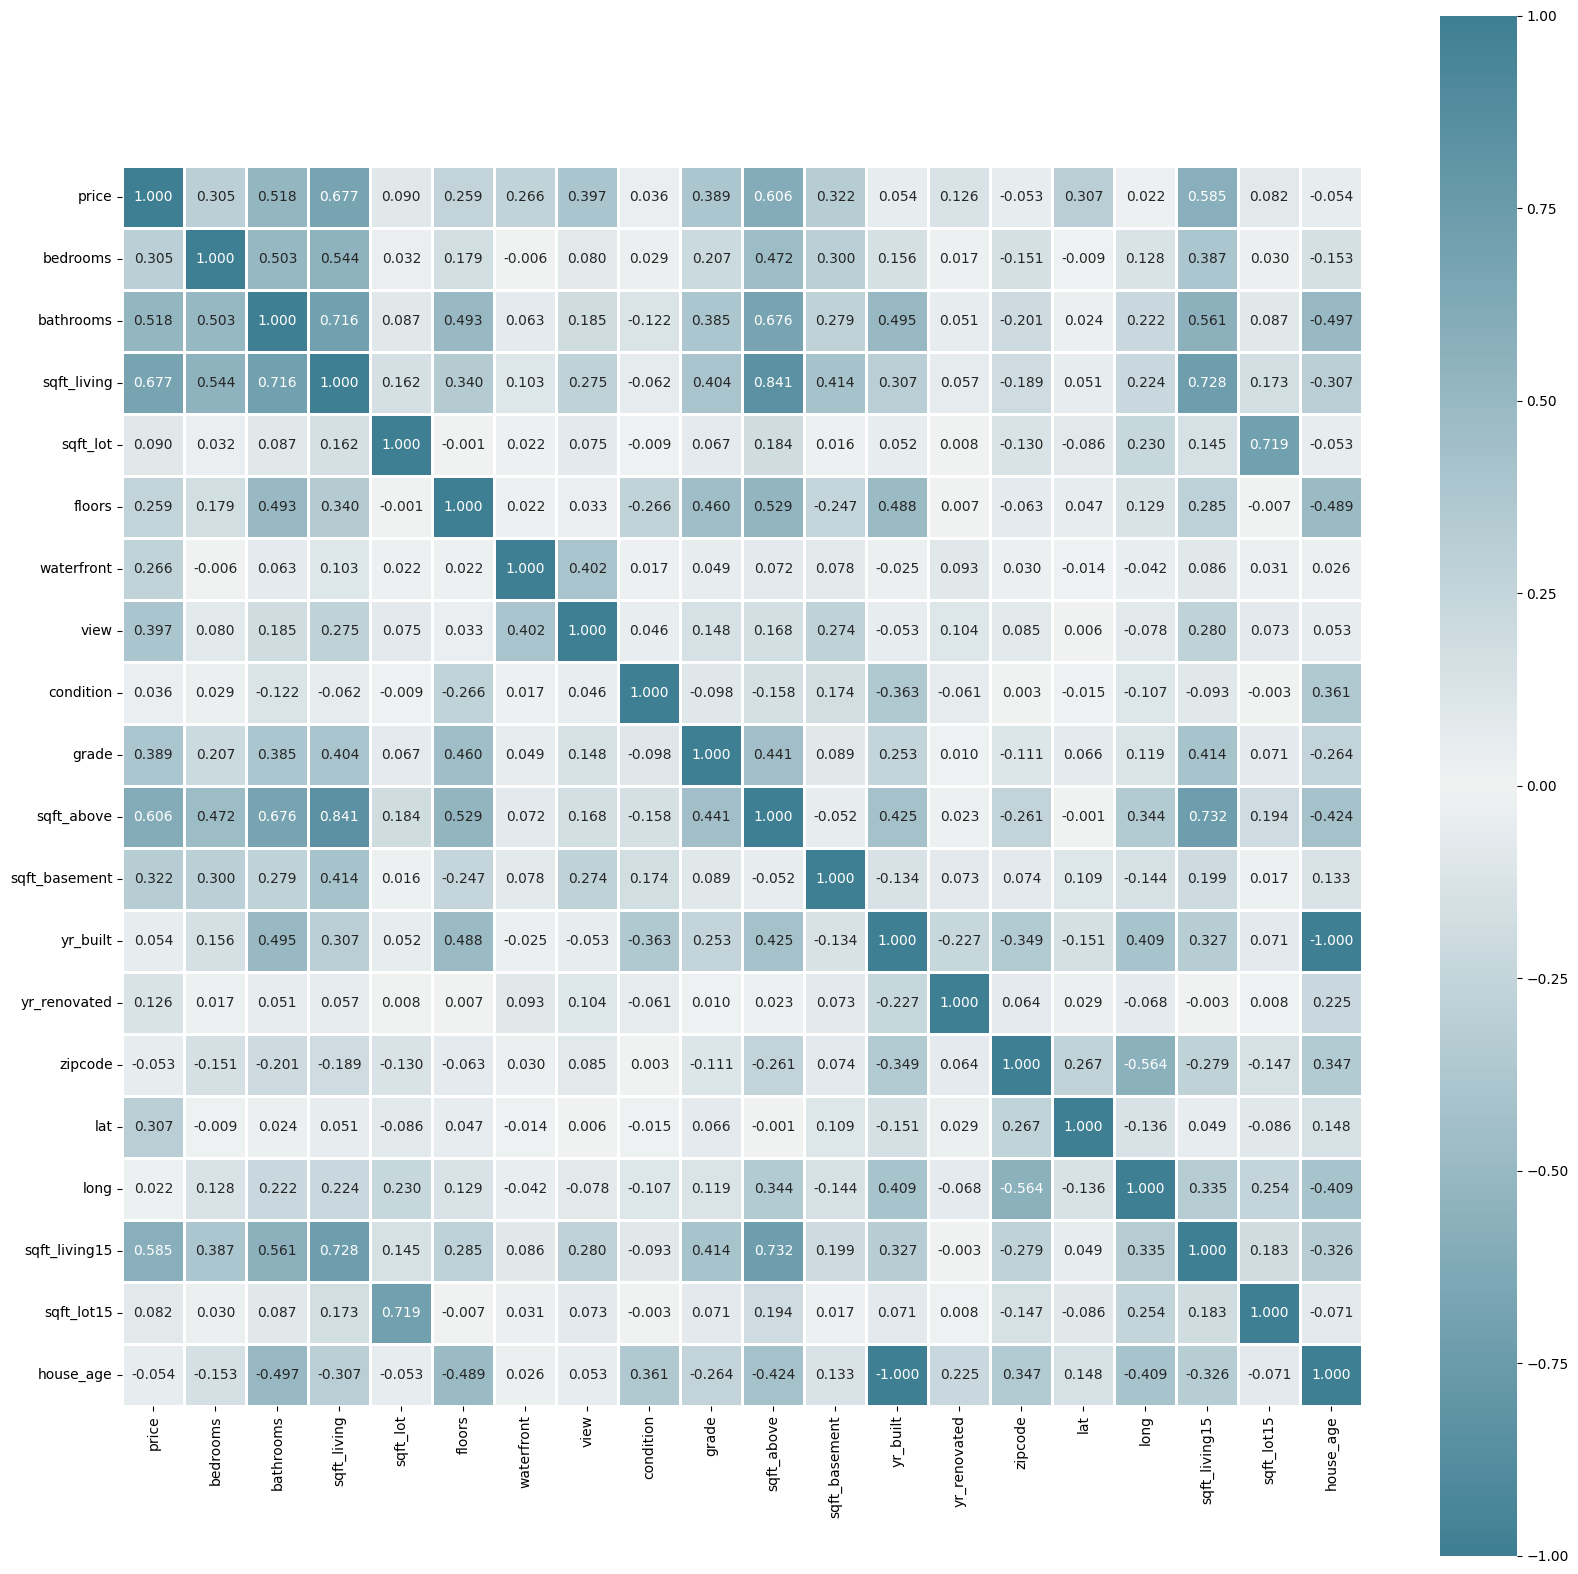

In [22]:
corr = data.corr()

plt.figure(figsize=(20, 20))
cmap = diverging_palette(220, 220, as_cmap=True)
heatmap(corr, annot=True, fmt=".3f", cmap = cmap, linewidths=1, square=True, center=0, vmax=1, vmin=-1)
plt.show()

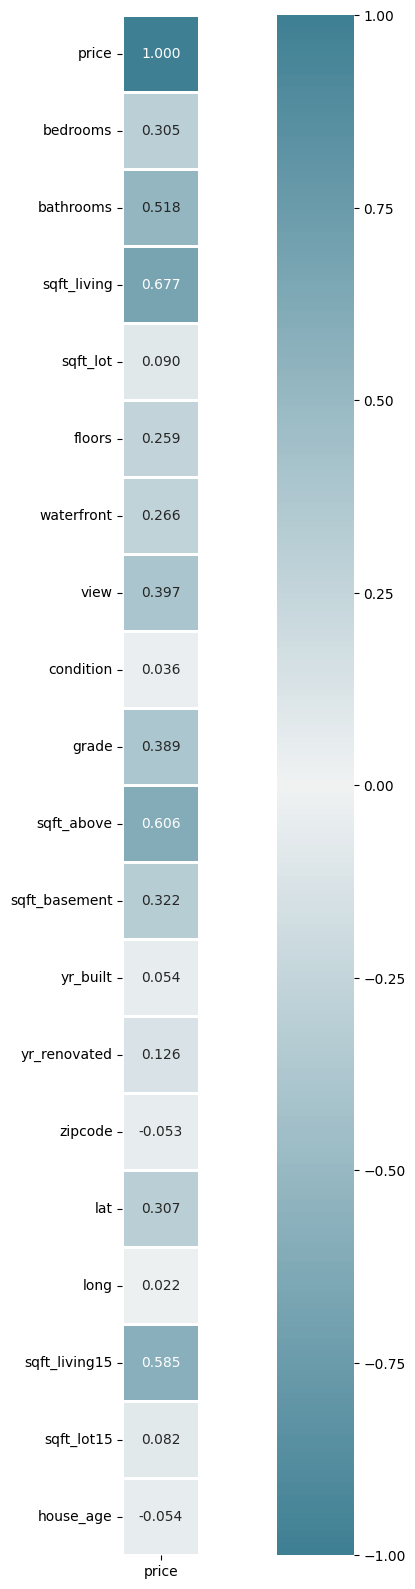

In [23]:
corr = corr[['price']]

plt.figure(figsize=(20, 20))
cmap = diverging_palette(220, 220, as_cmap=True)
heatmap(corr, annot=True, fmt=".3f", cmap = cmap, linewidths=1, square=True, center=0, vmax=1, vmin=-1)
plt.show()

date :


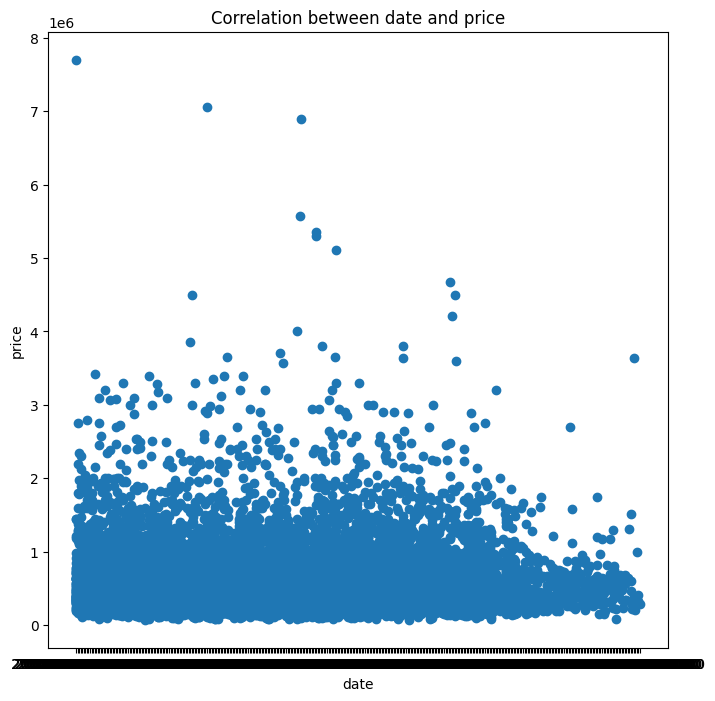

bedrooms :
corr = 0.3045213753390751


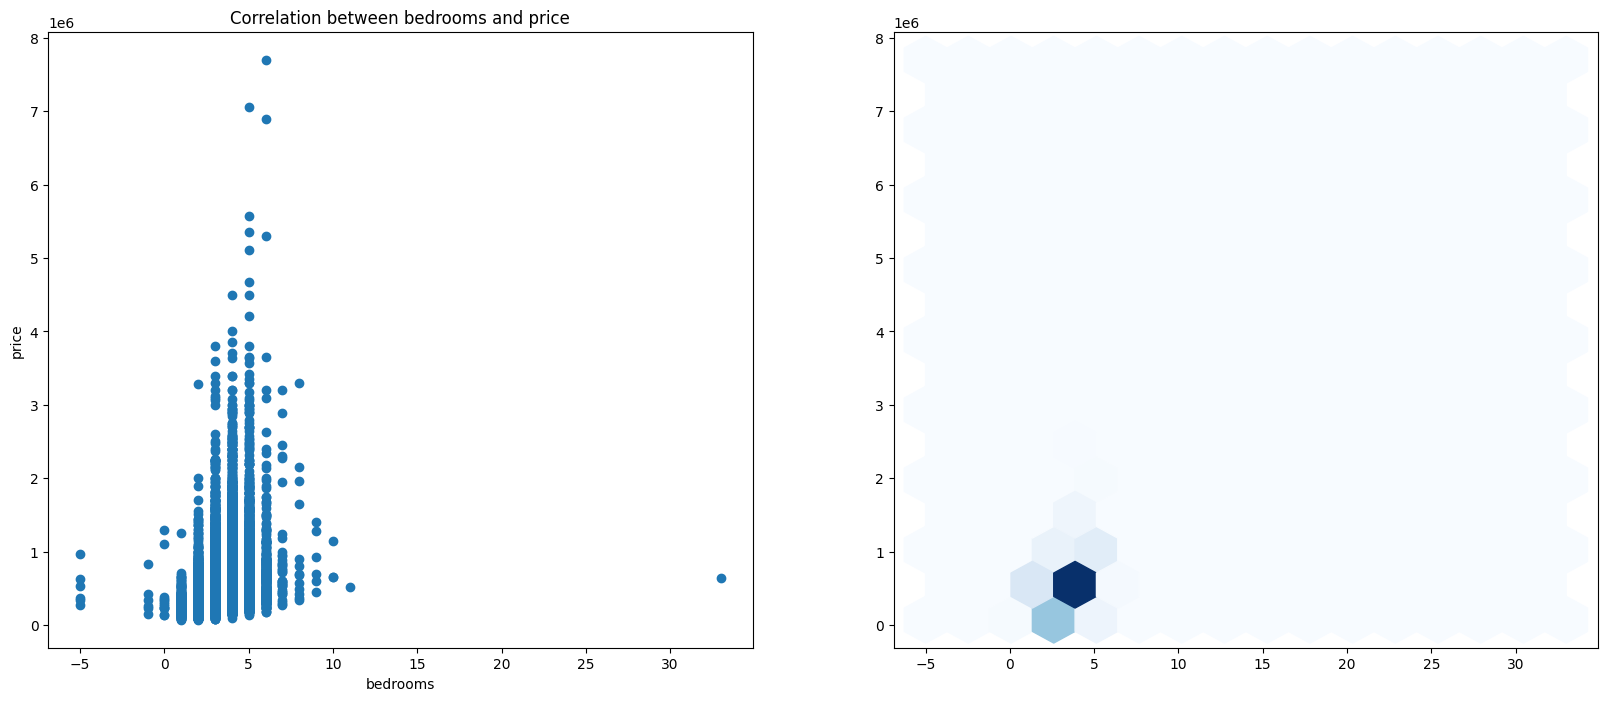

bathrooms :
corr = 0.5179521869667695


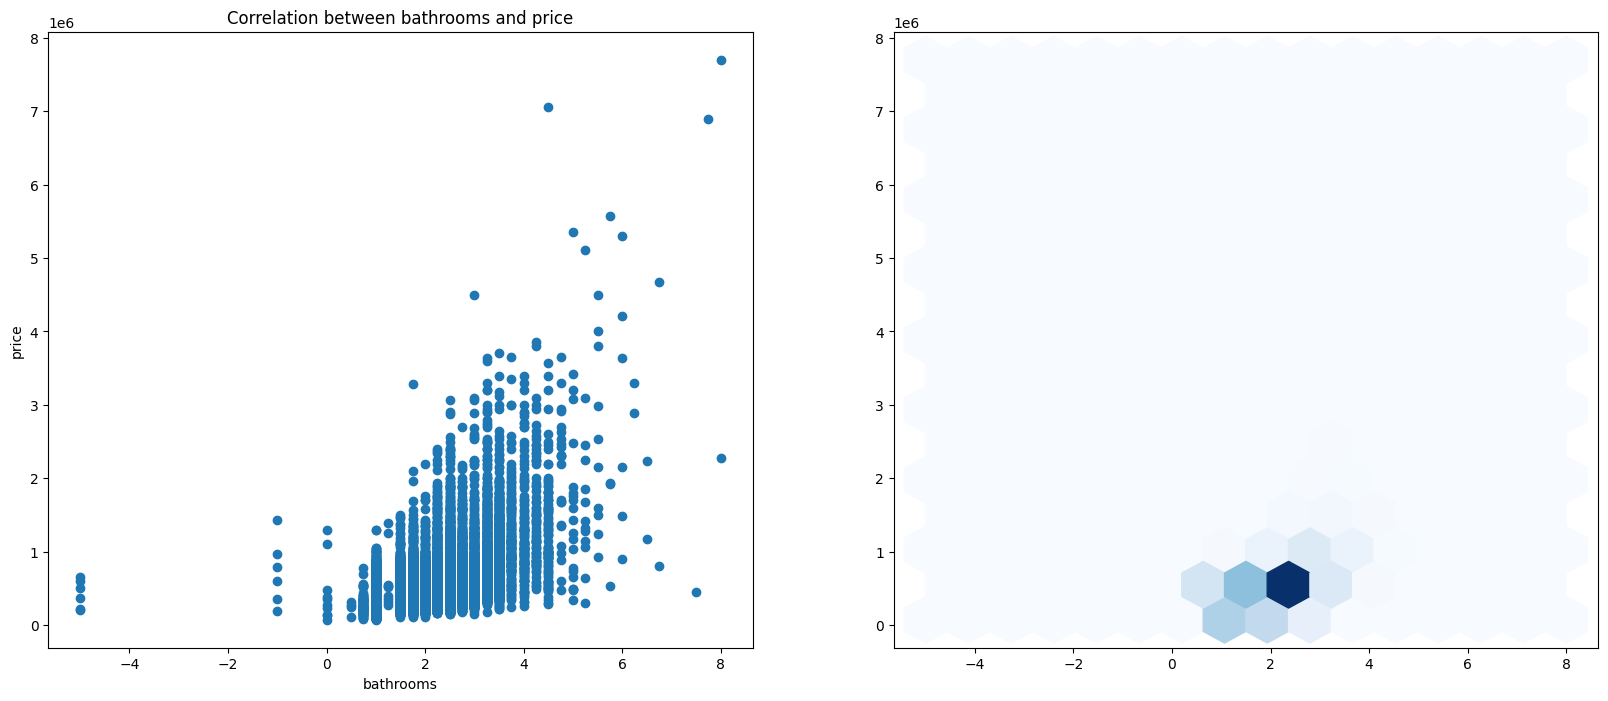

sqft_living :
corr = 0.6765416460191007


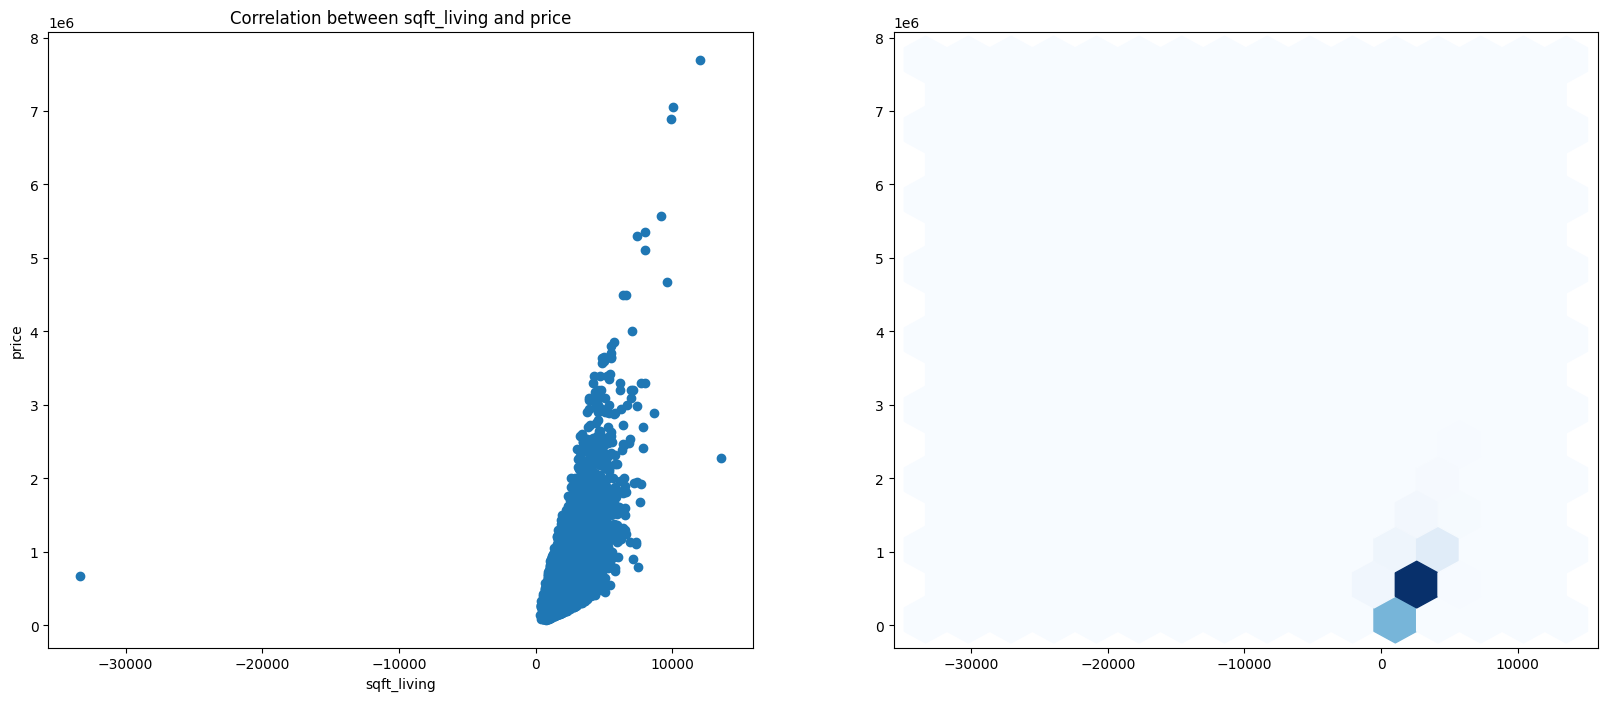

sqft_lot :
corr = 0.08965520771082389


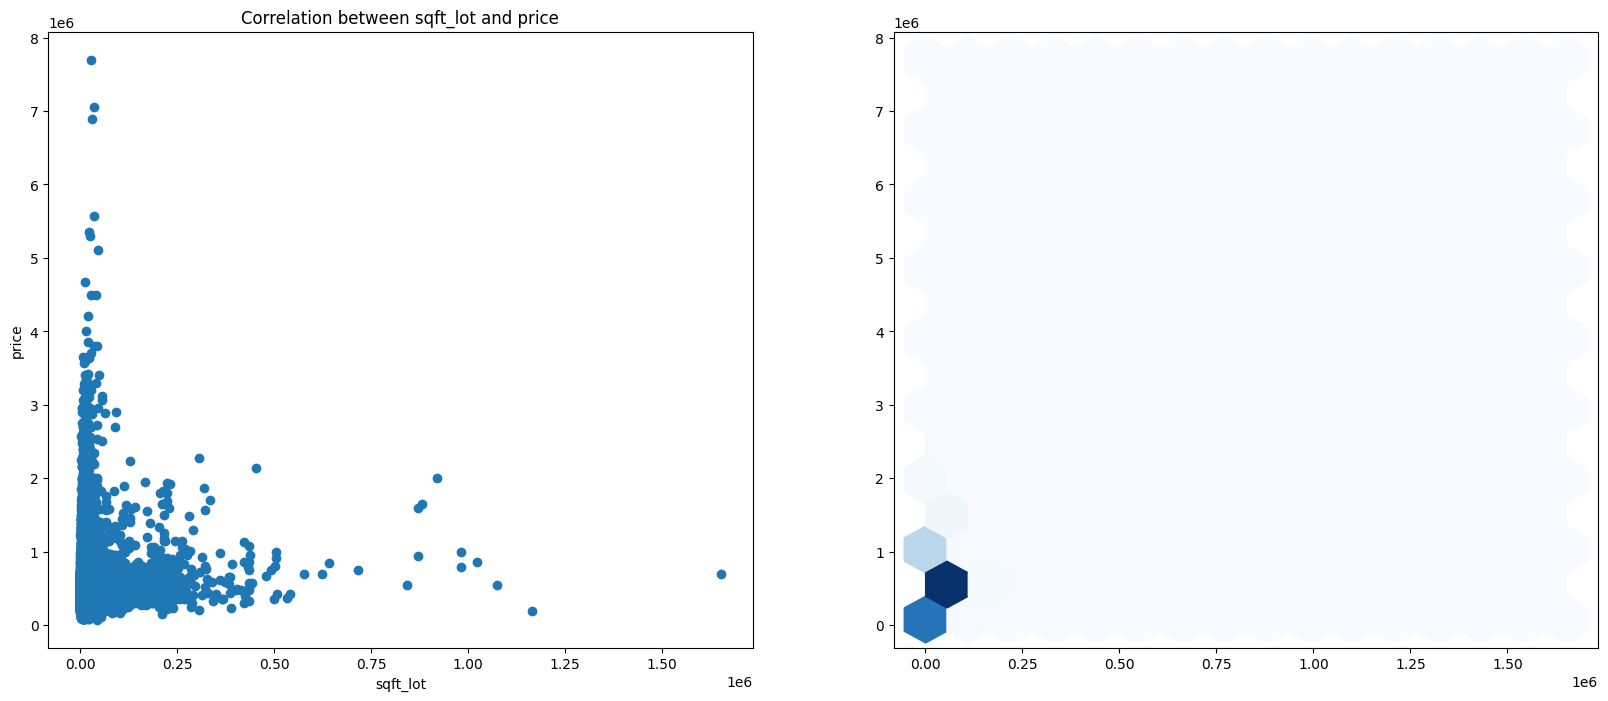

floors :
corr = 0.258602909722048


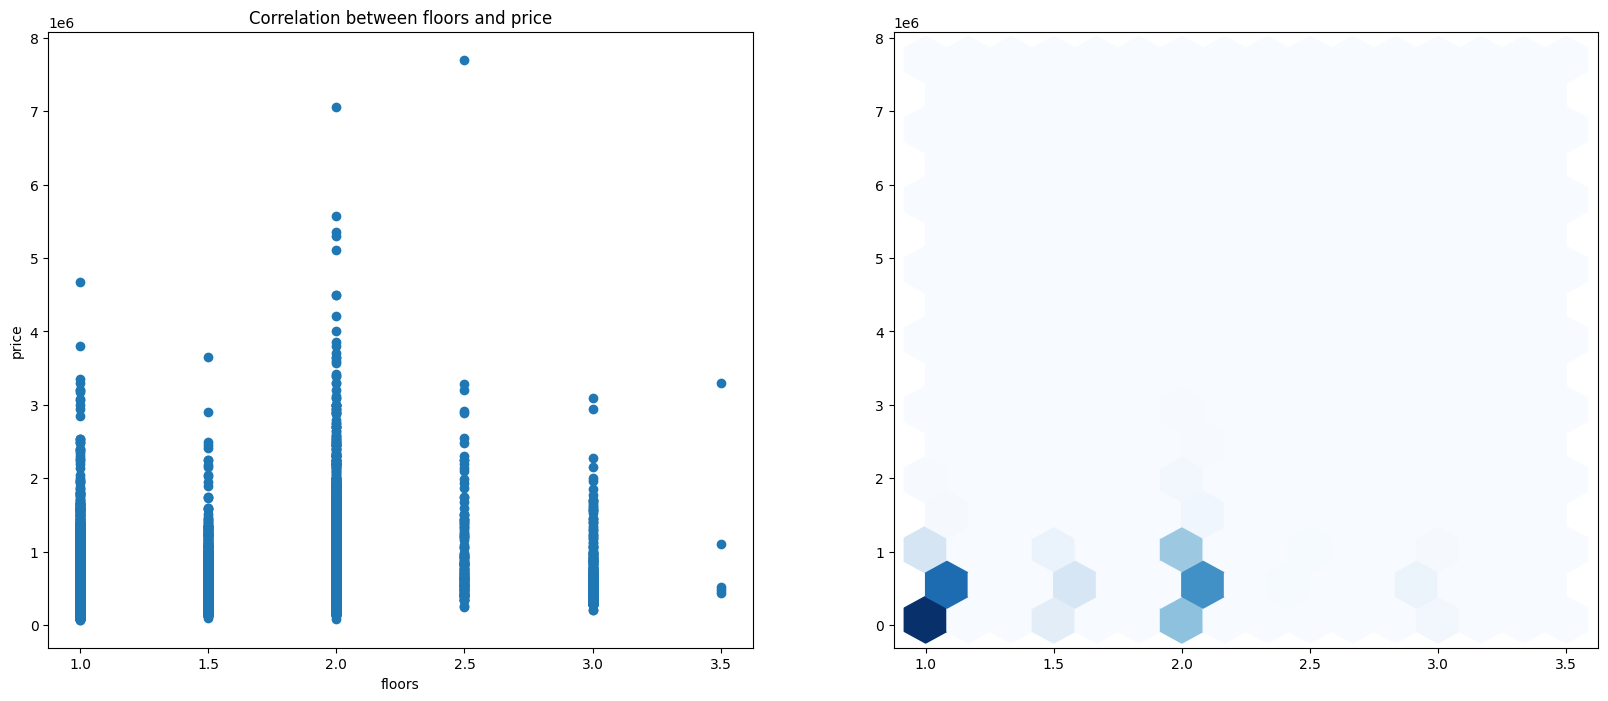

waterfront :
corr = 0.2663305105222563


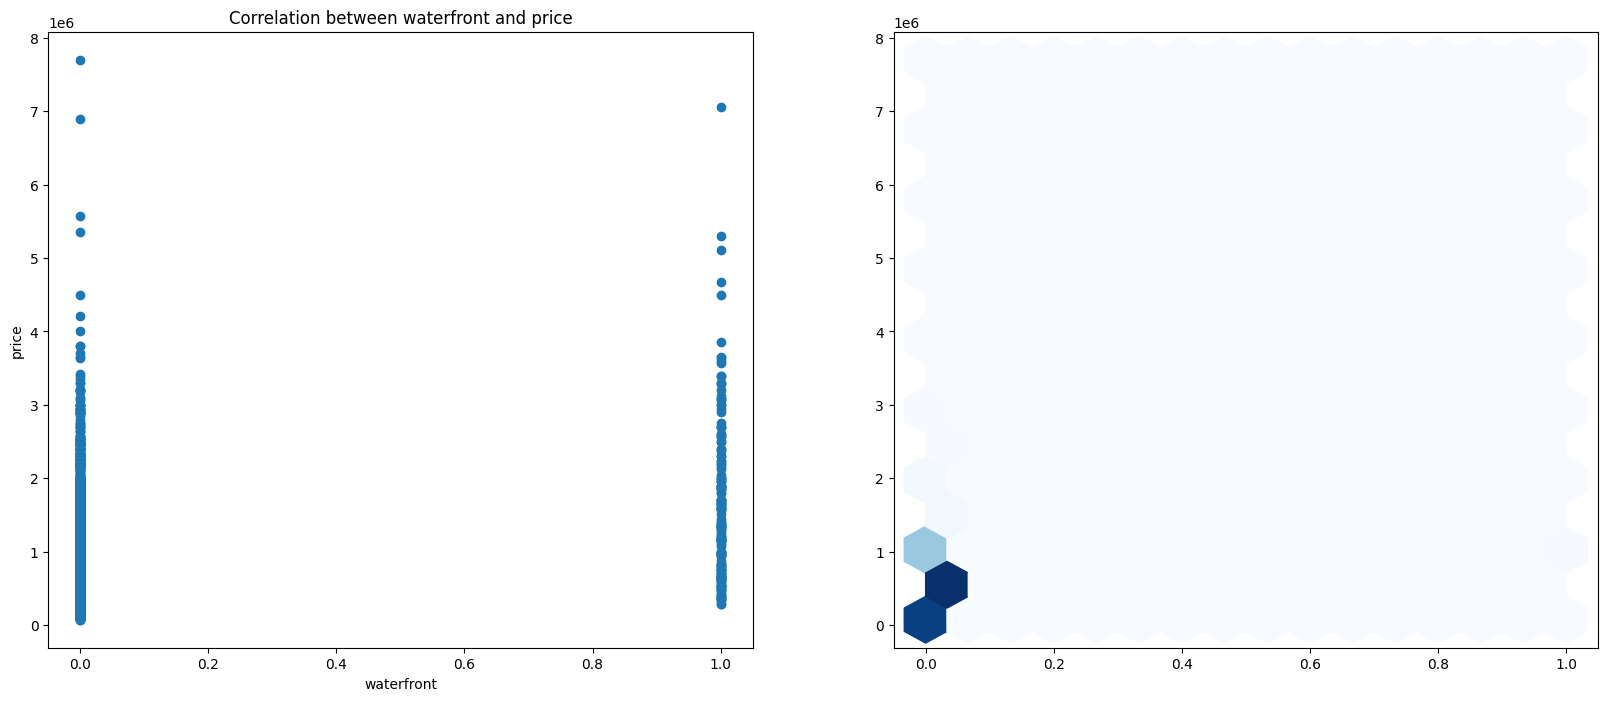

view :
corr = 0.3973464743789386


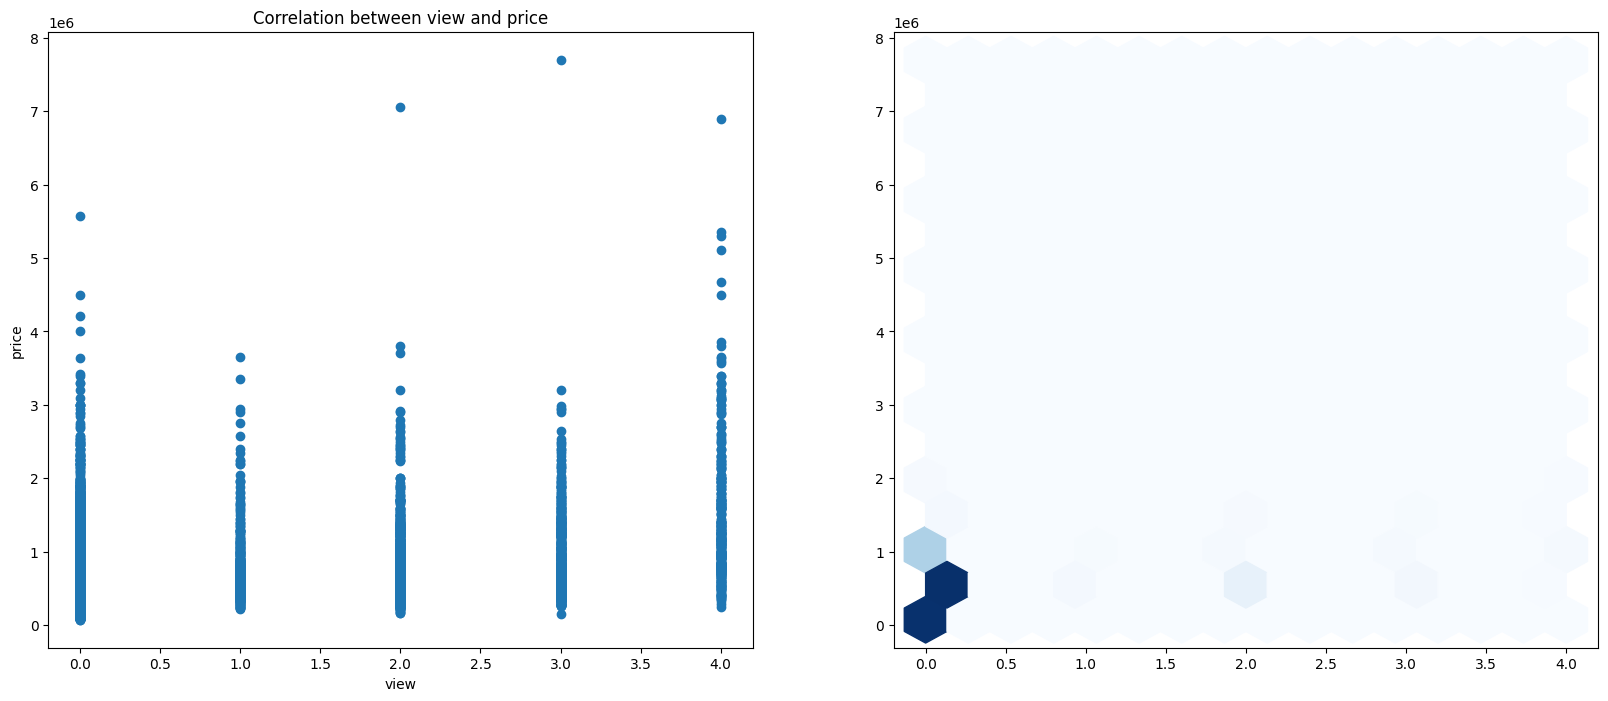

condition :
corr = 0.036391921410228255


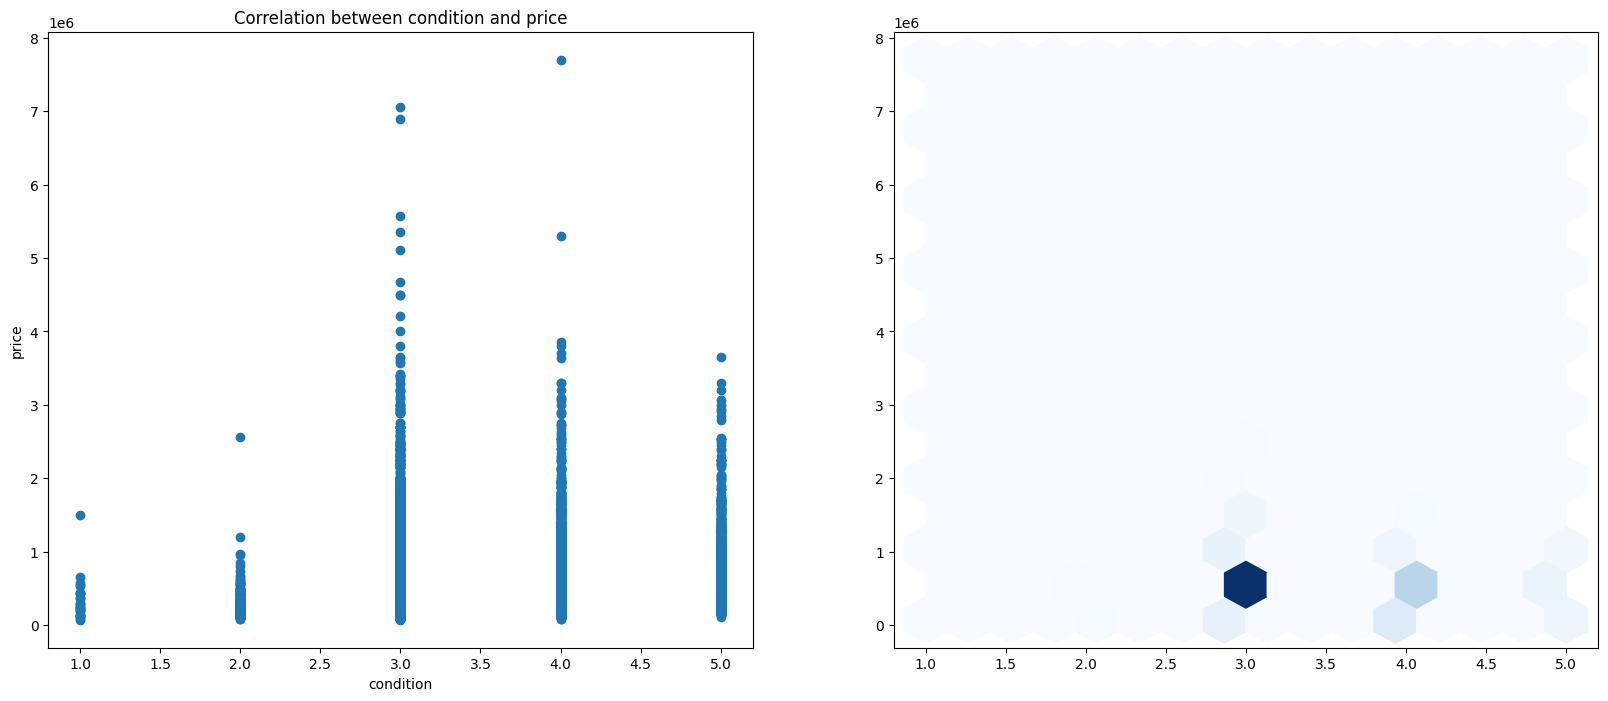

grade :
corr = 0.3892269515623083


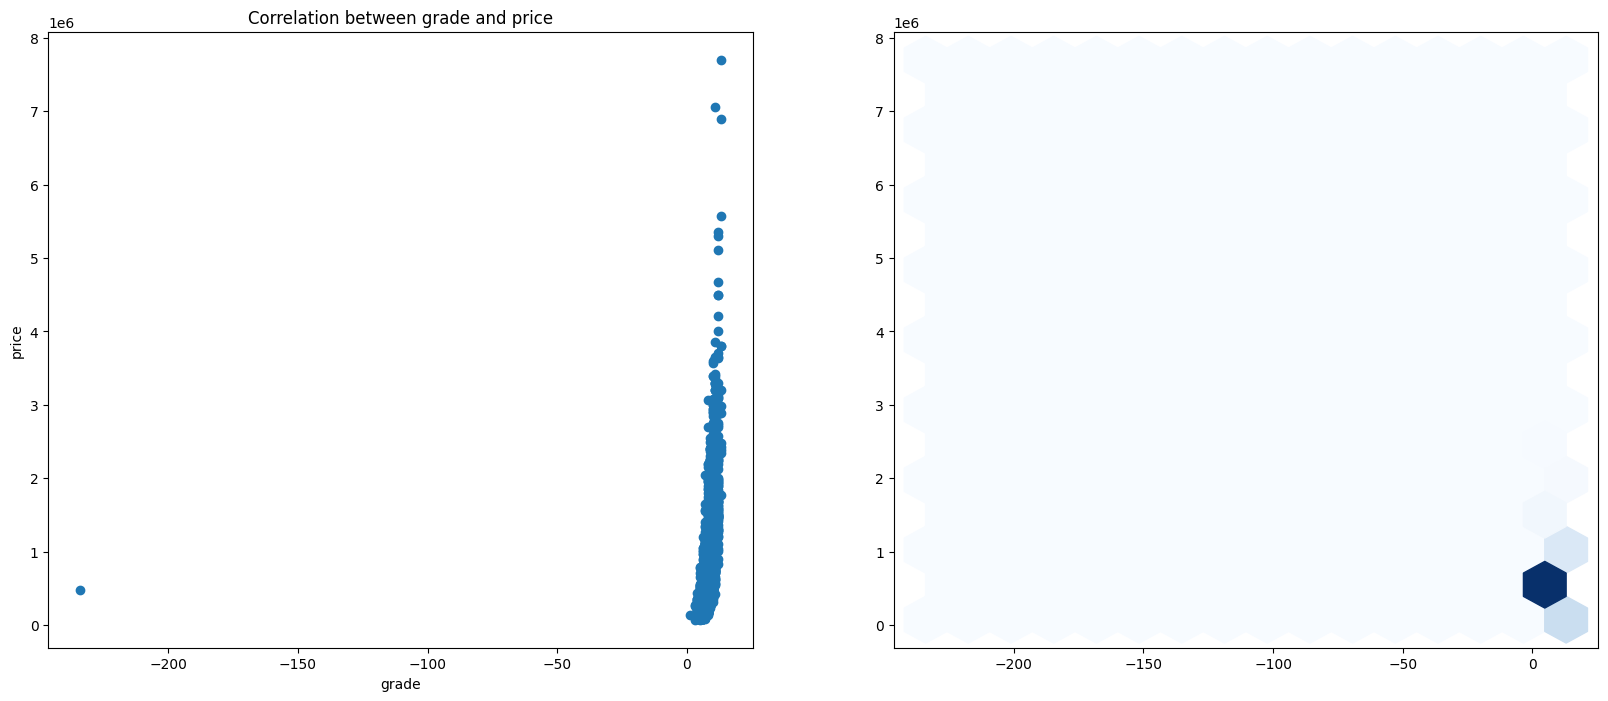

sqft_above :
corr = 0.6055655067254432


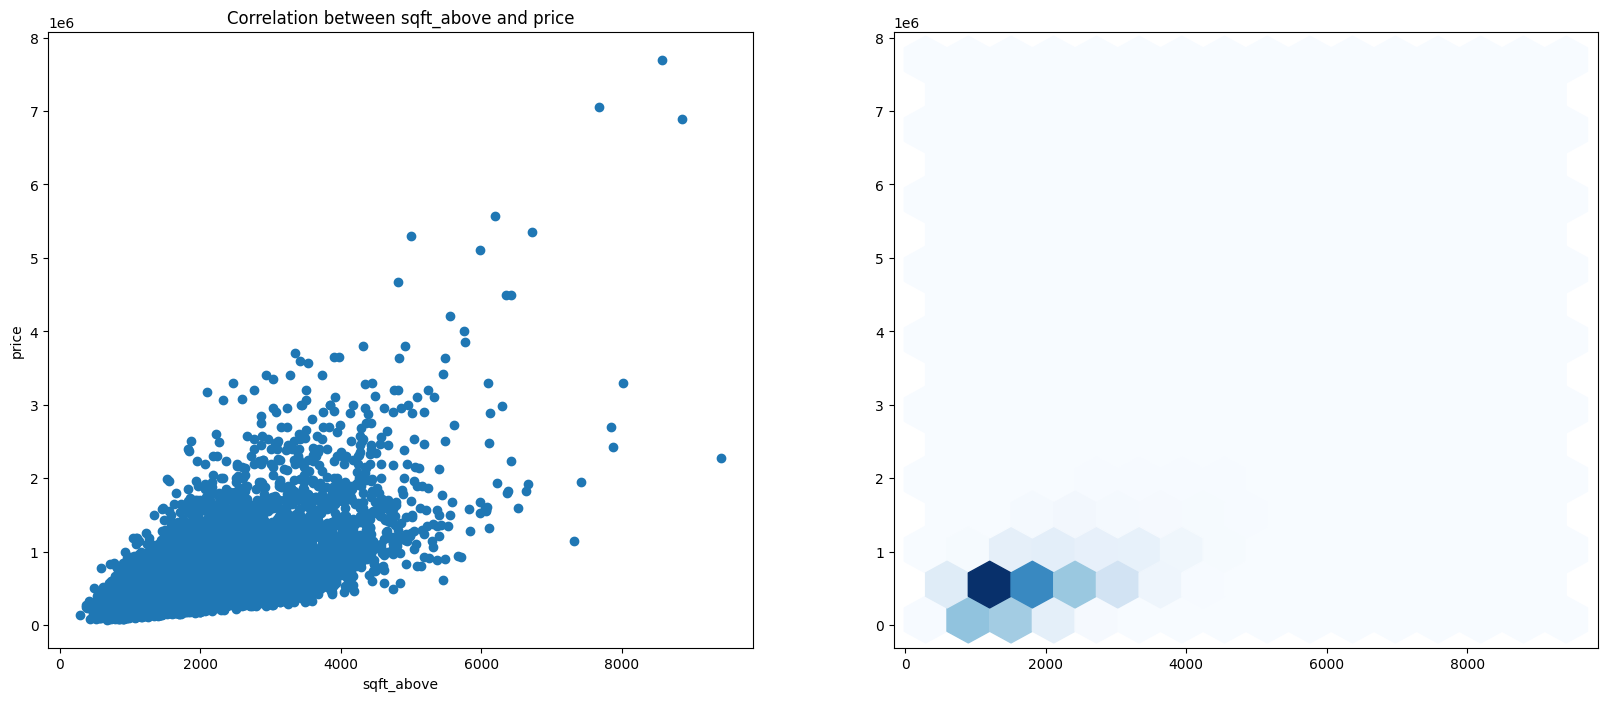

sqft_basement :
corr = 0.3218247068325435


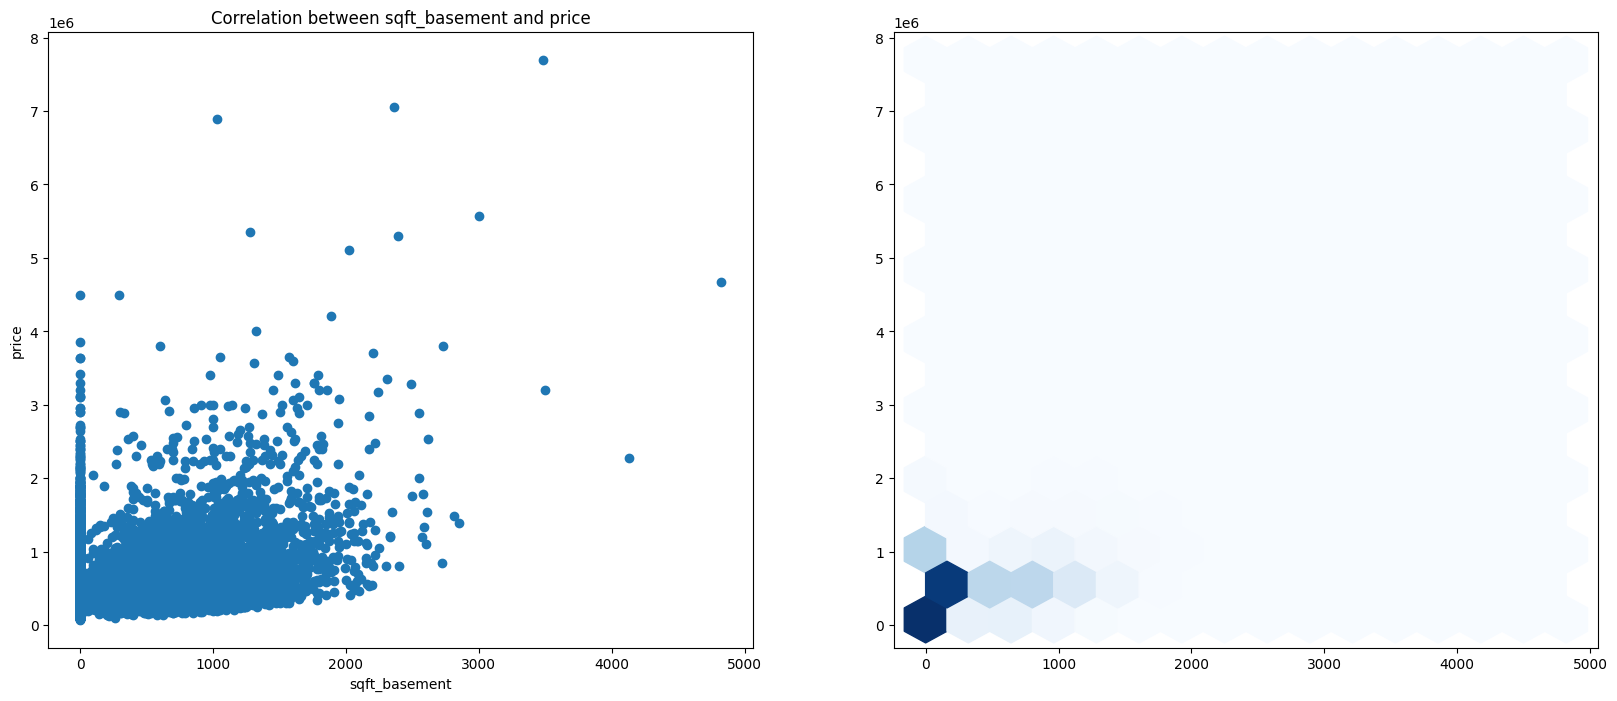

yr_built :
corr = 0.05411762124019397


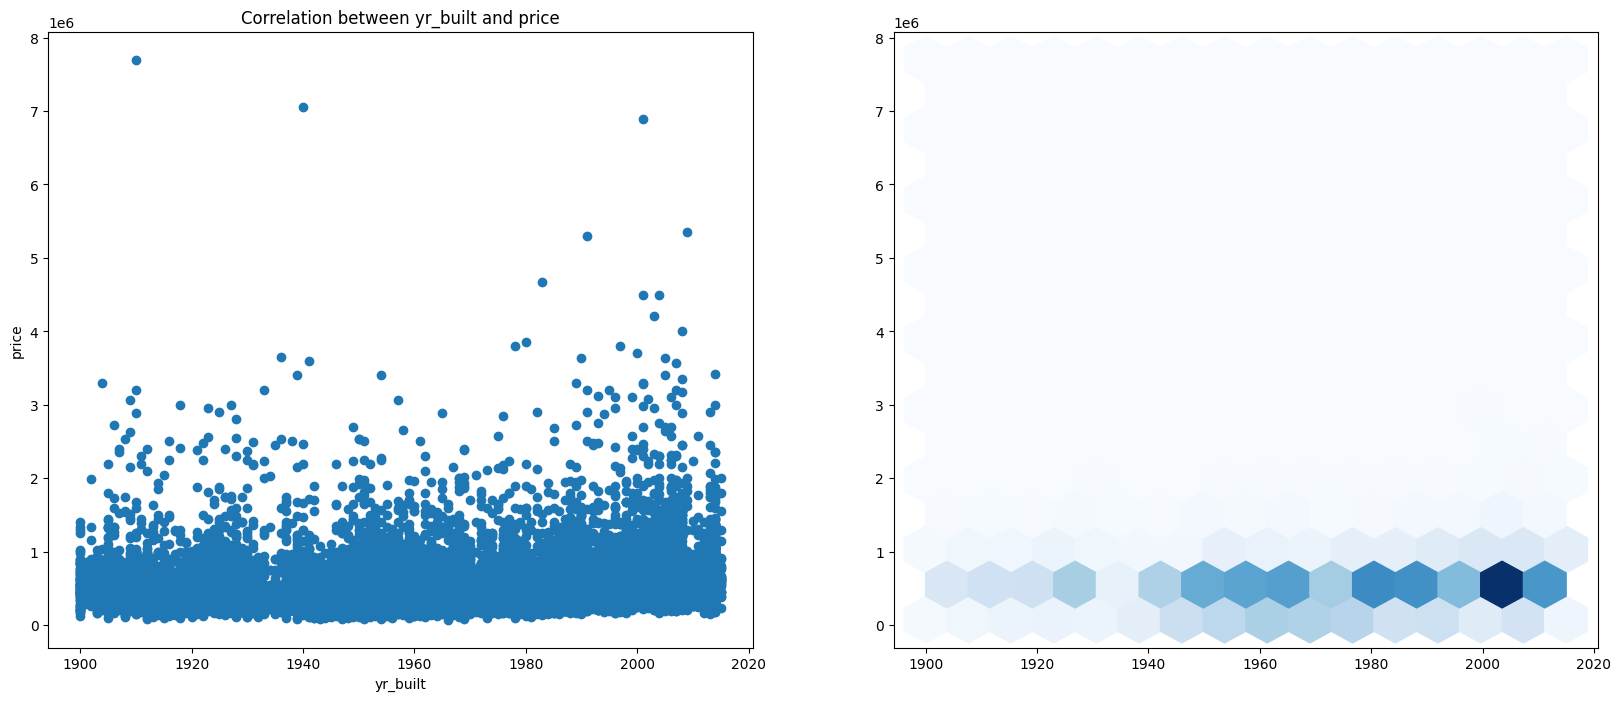

yr_renovated :
corr = 0.12644222895207075


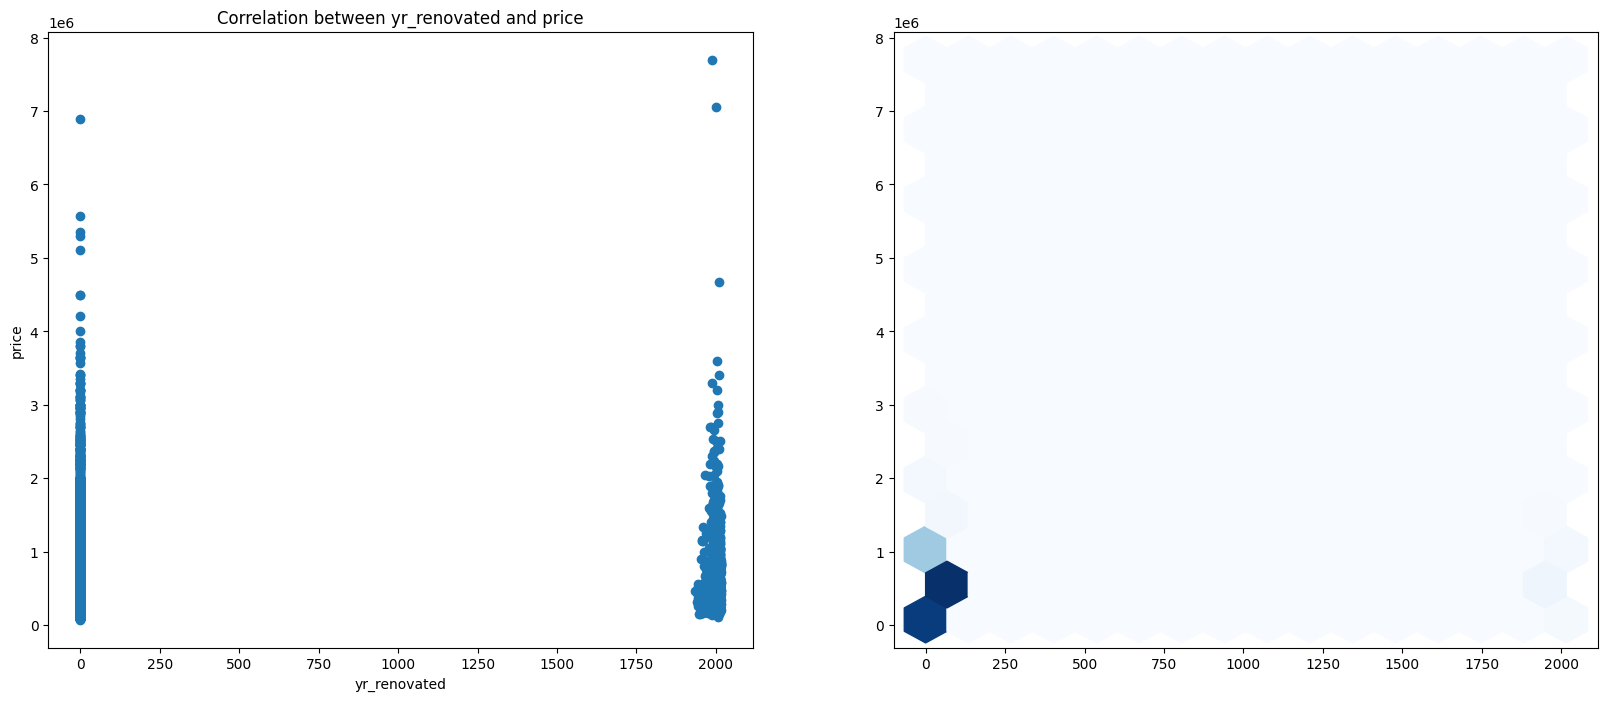

zipcode :
corr = -0.05316819852916173


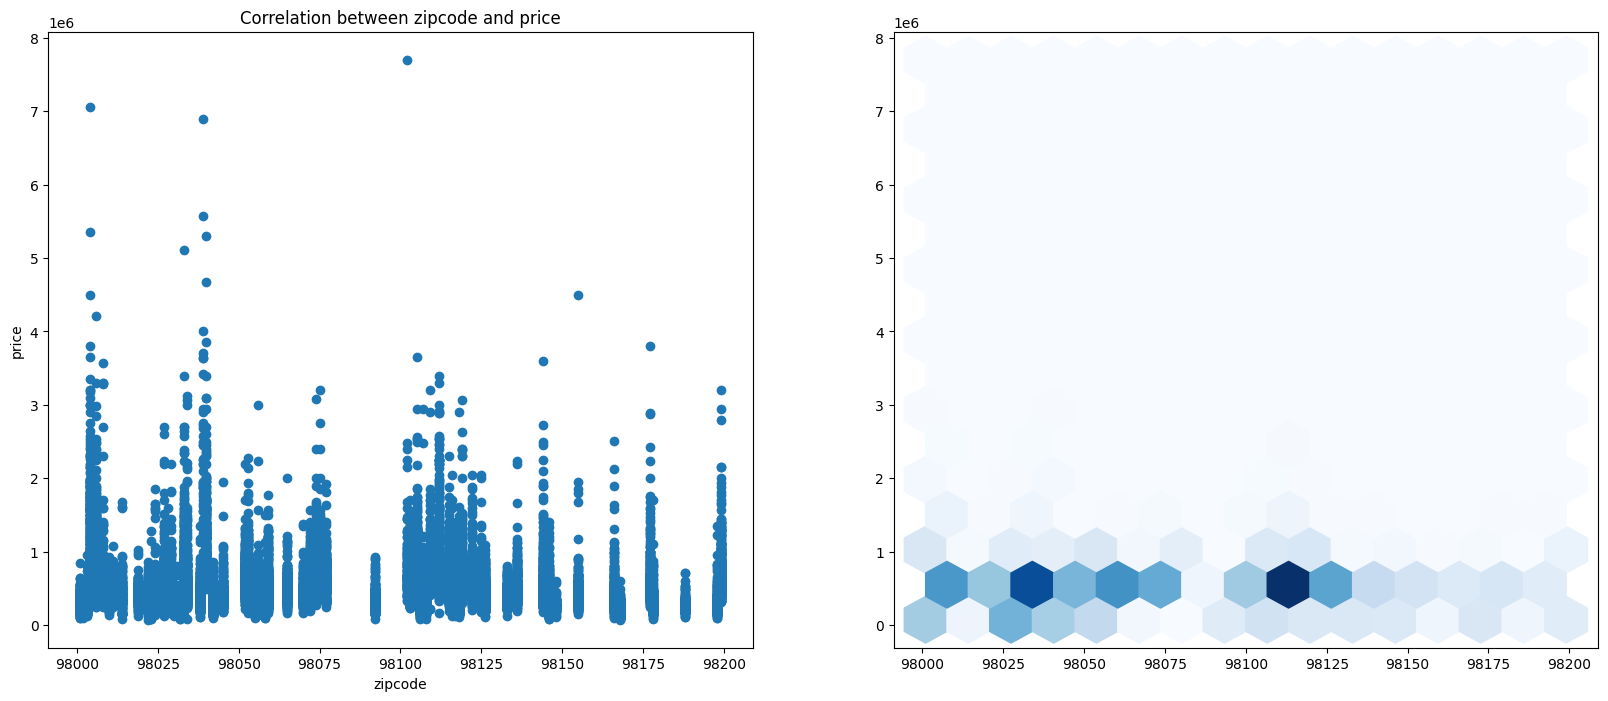

lat :
corr = 0.3069187697461545


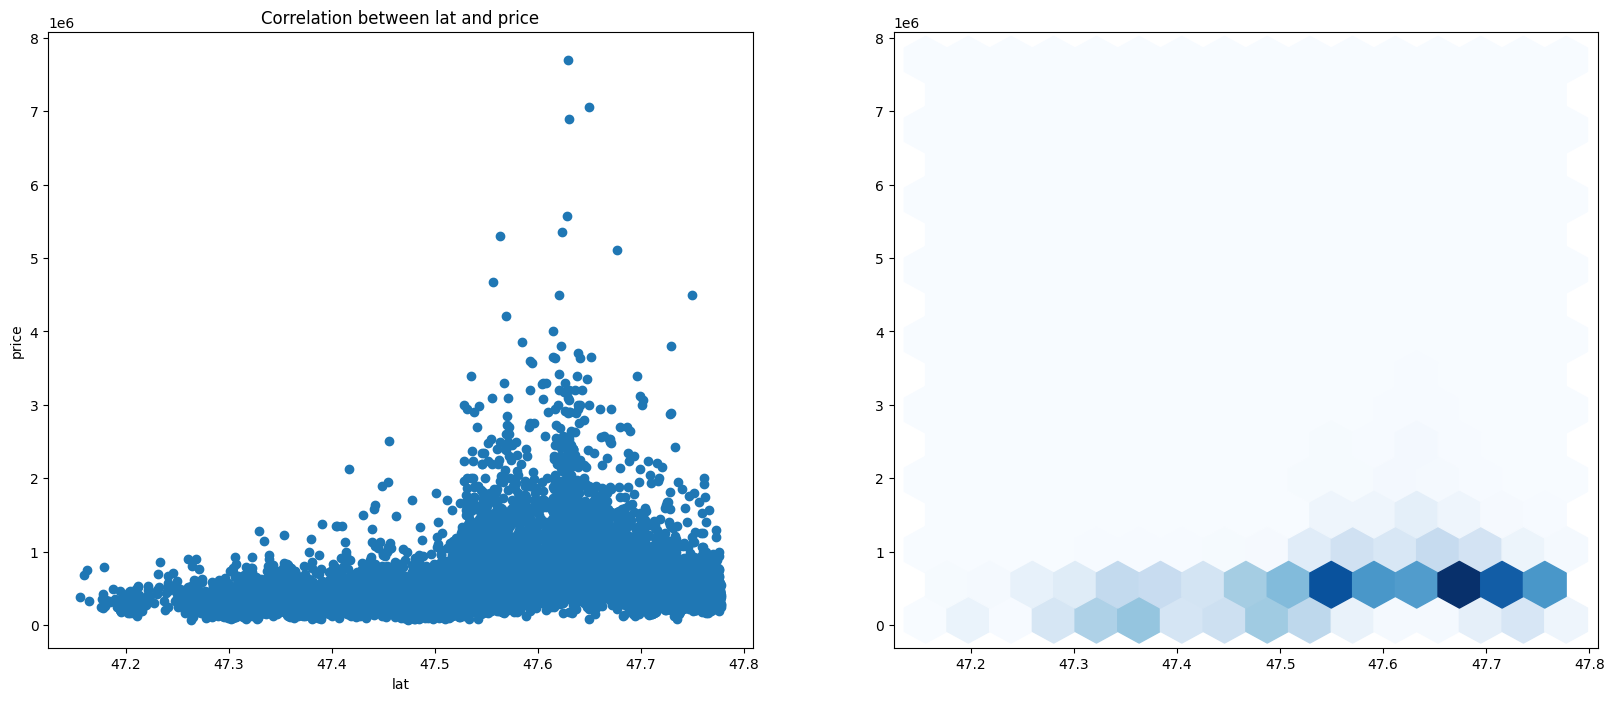

long :
corr = 0.021570791442365445


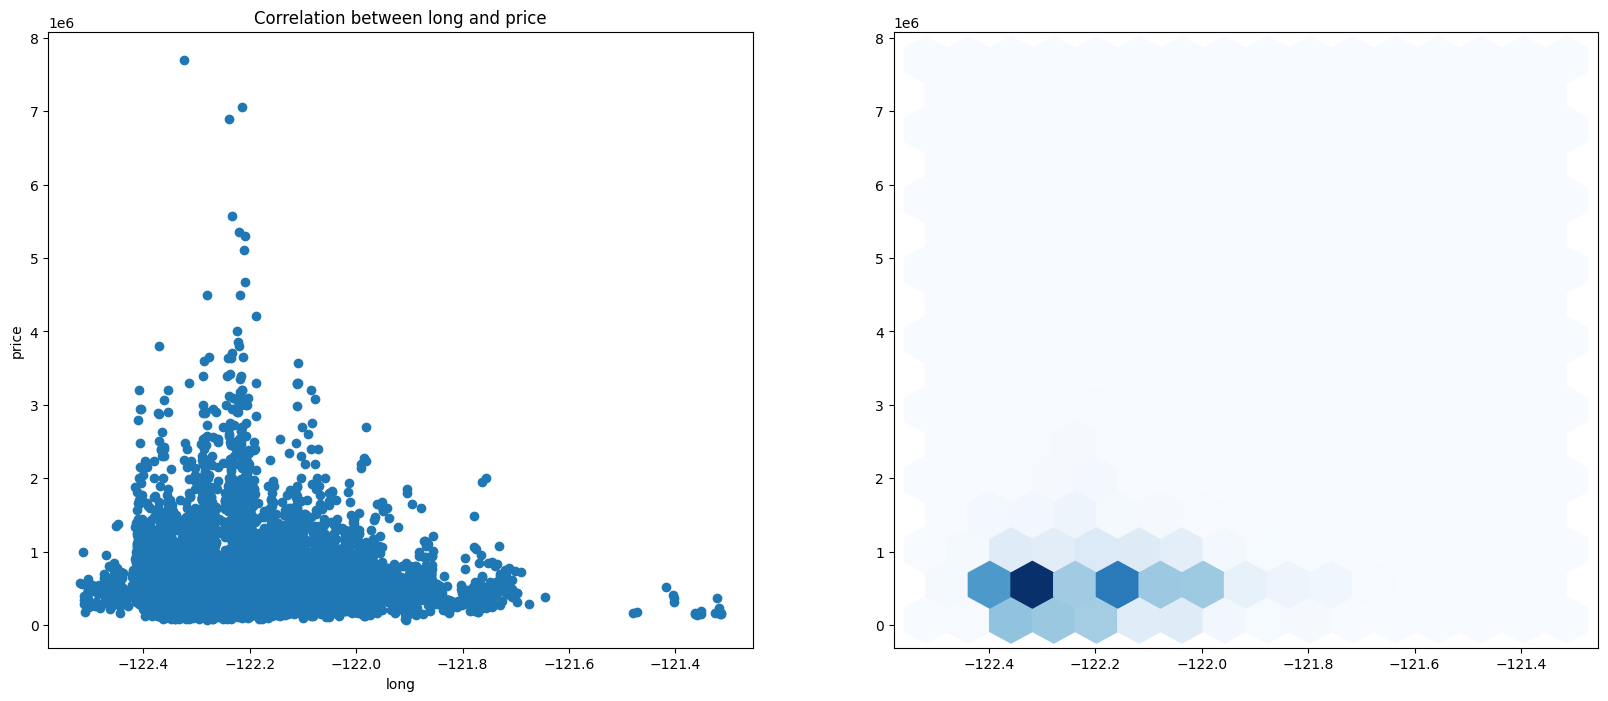

sqft_living15 :
corr = 0.5853740063171515


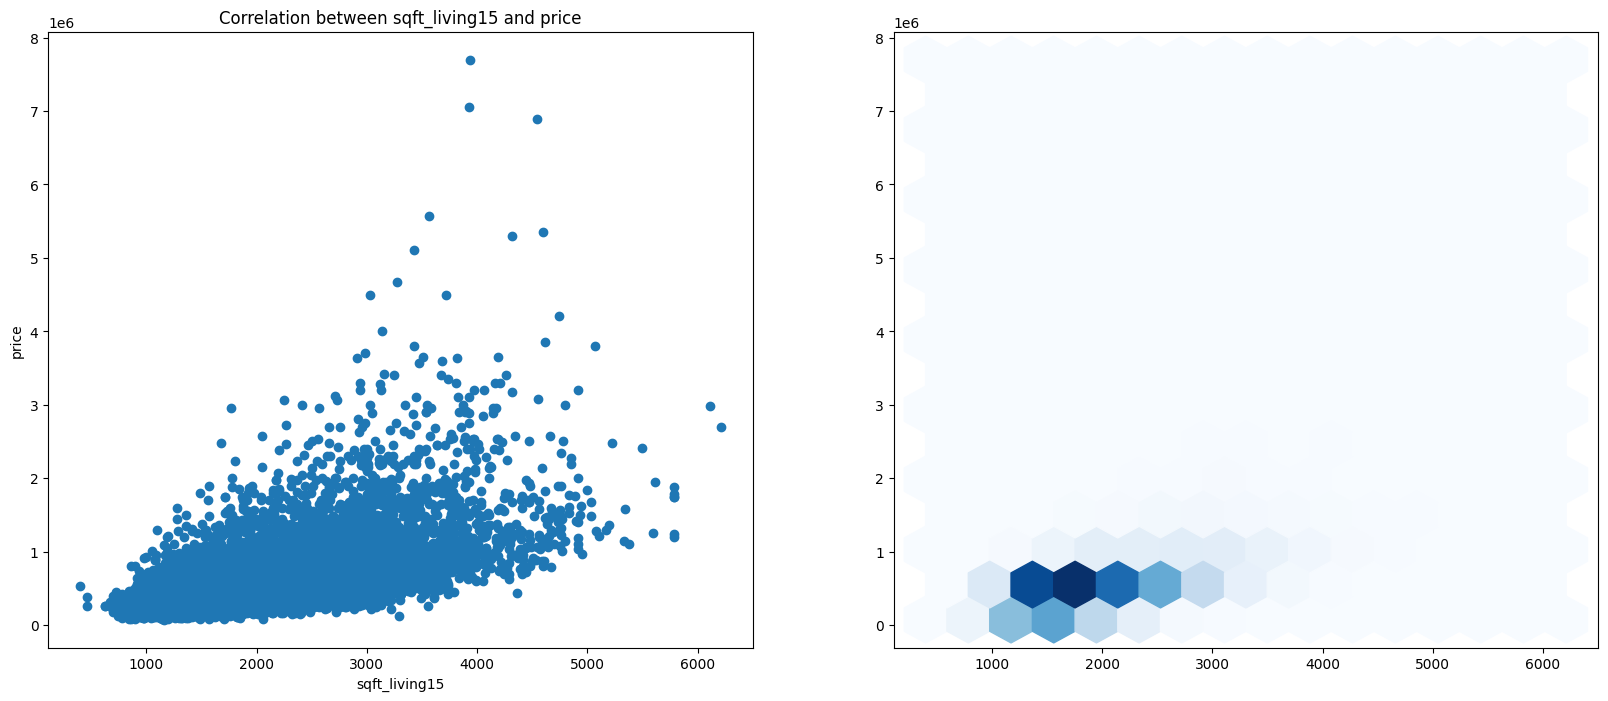

sqft_lot15 :
corr = 0.08245554631109098


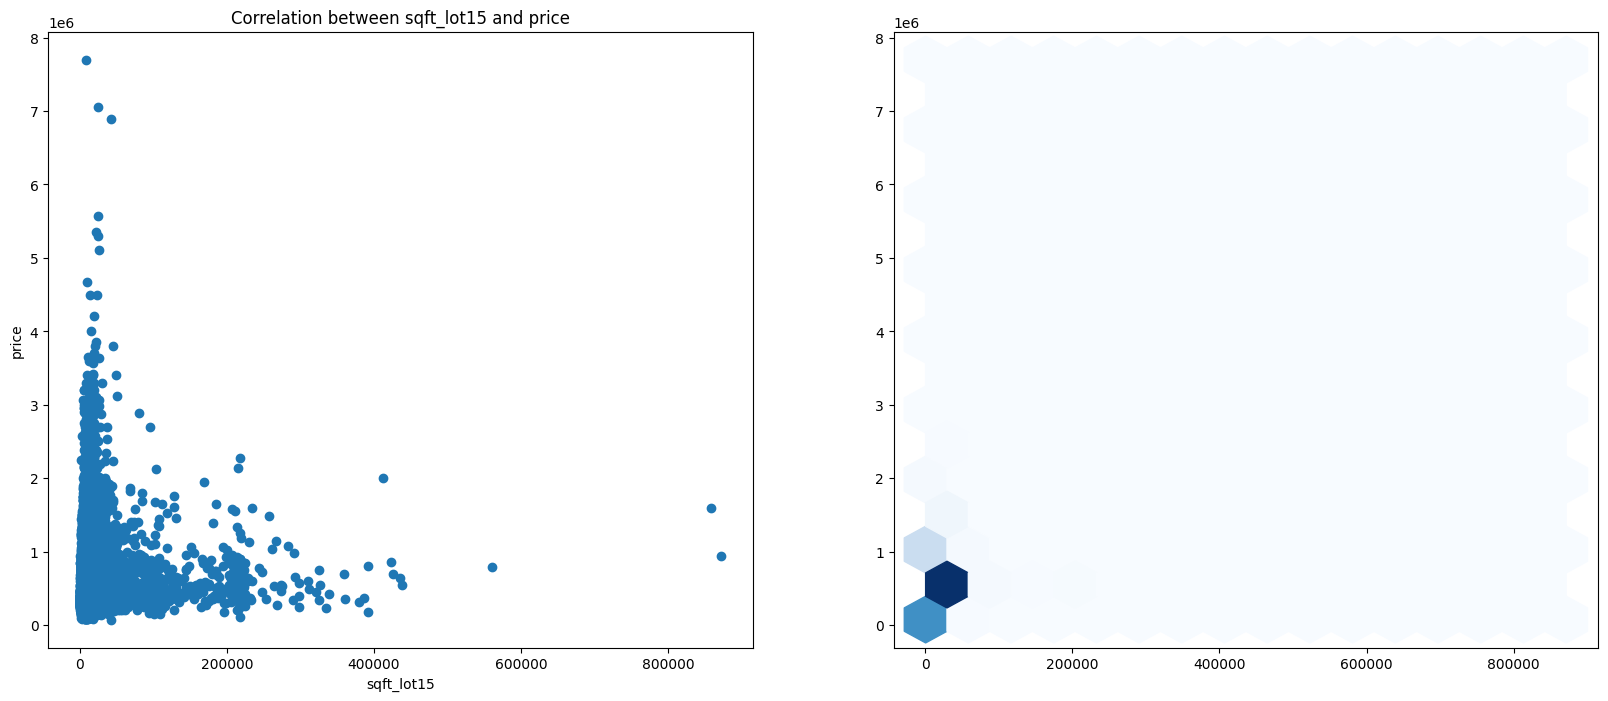

location :


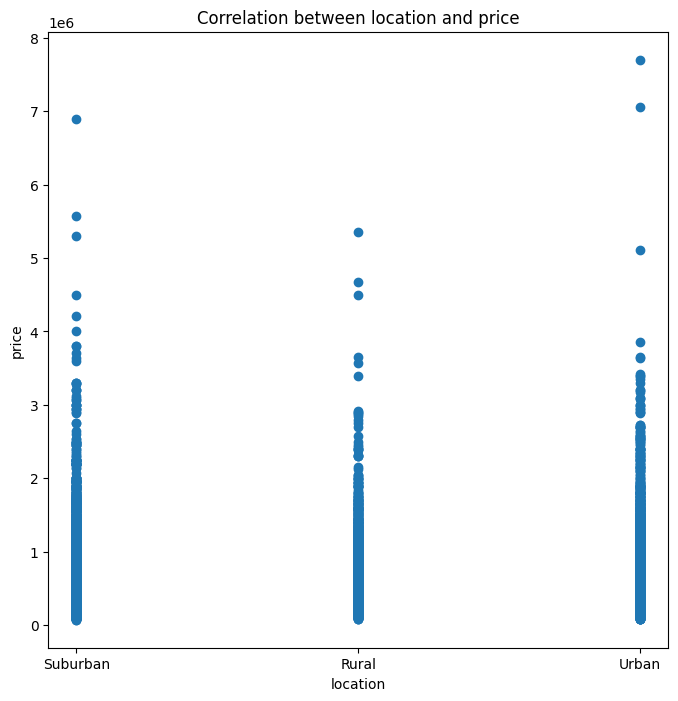

style :


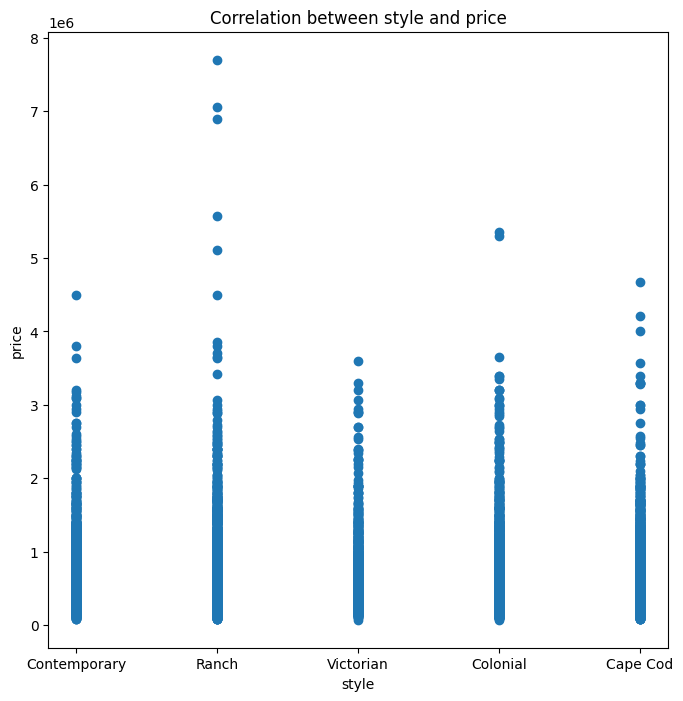

house_age :
corr = -0.05398182517966191


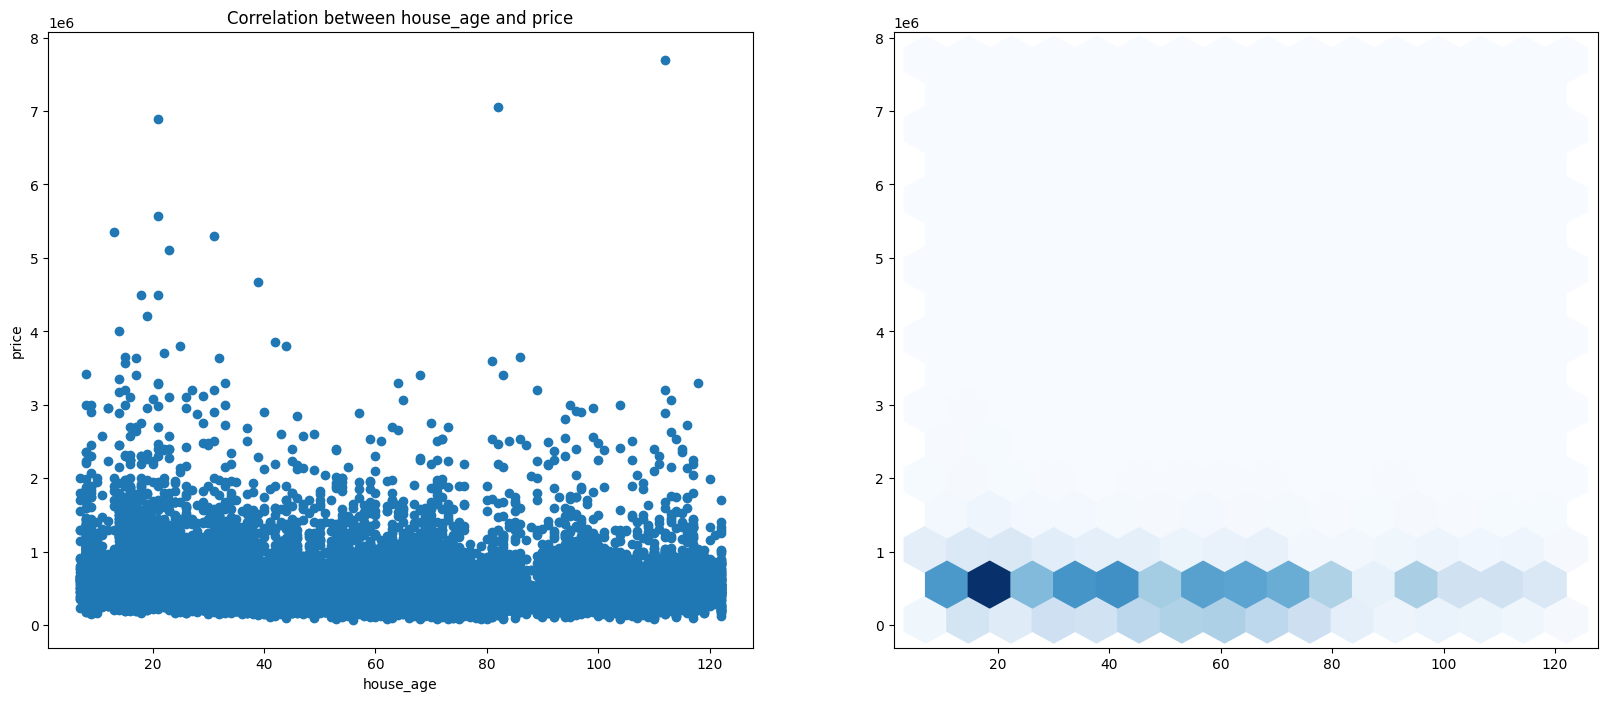

In [24]:
for col in data.columns:
    if(col == 'price'):
        continue

    print(col, ':')

    if(data[col].dtype != 'object'):
        corr = data[col].corr(data['price'])
        print(f"corr = {corr}")
        fig, axs = plt.subplots(1, 2, figsize=(20,8))
        axs[1].hexbin(x = data[col], y = data['price'], gridsize = 15, cmap='Blues')
        axs[0].scatter(data[col], data['price'])
        axs[0].set_title("Correlation between " + col + " and price")
        axs[0].set_xlabel(col)
        axs[0].set_ylabel("price")
    
    else:
        fig, axs = plt.subplots(1, 1, figsize=(8,8))
        
        axs.scatter(data[col], data['price'])
        axs.set_title("Correlation between " + col + " and price")
        axs.set_xlabel(col)
        axs.set_ylabel("price")
    
    plt.show()


## 1.5 removing noises and unmeaning values

As we see, there is some negative values, only `long` feature can be negative.

According to datas about house, floor can be 1.5 and it make sense.

In [25]:
neg_cols = pre.get_neg_cols()

neg_cols.remove('long')
negative_rows = data[data.loc[:, neg_cols] < 0].dropna(how='all')

display(negative_rows)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,location,style,house_age
66,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1568,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1880,NaN,NaN,-5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2436,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2989,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4740,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5477,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5674,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6062,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


there is only 26 data with illegal negative values, so we drop them

In [26]:
data.drop(negative_rows.index, axis = 0, inplace=True)
pre.get_neg_cols()

['long']

## 1.6 Detect and analyze high correlation values

In [27]:
CORR_CUTOFF = 0.1

high_corr = data.corr()['price'].drop(['price'])
high_corr = high_corr[abs(high_corr) > CORR_CUTOFF]
print(high_corr)

bedrooms         0.308184
bathrooms        0.525080
sqft_living      0.703949
floors           0.258488
waterfront       0.266429
view             0.397136
grade            0.667413
sqft_above       0.605612
sqft_basement    0.321731
yr_renovated     0.126648
lat              0.306668
sqft_living15    0.585180
Name: price, dtype: float64


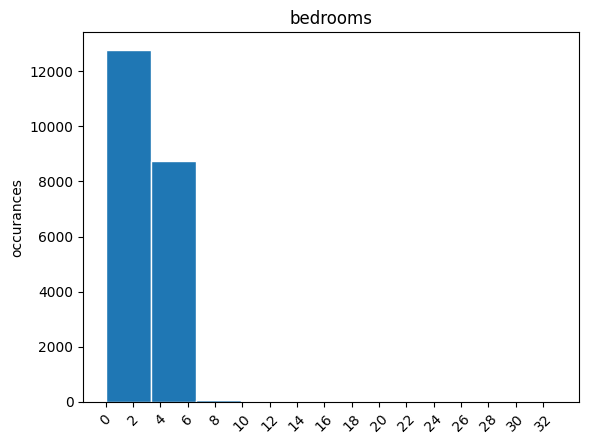

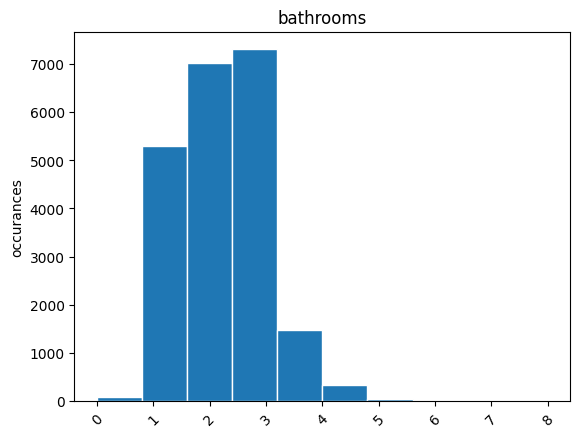

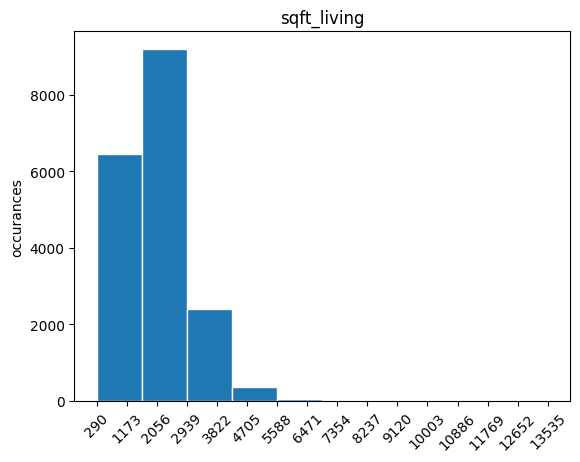

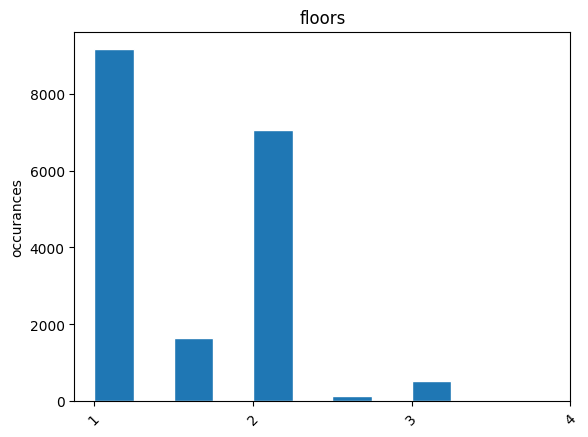

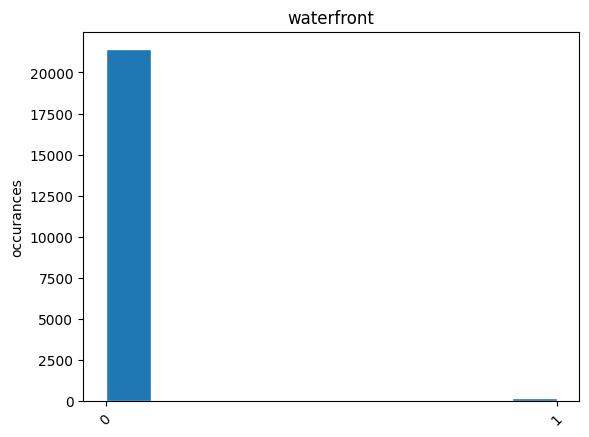

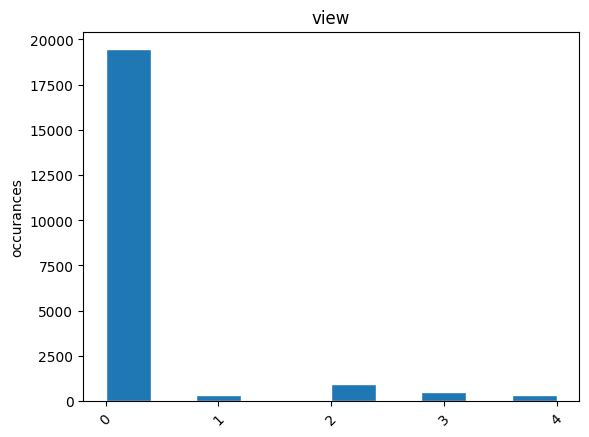

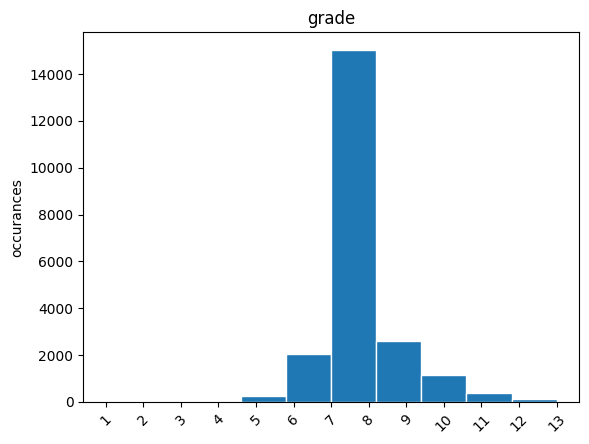

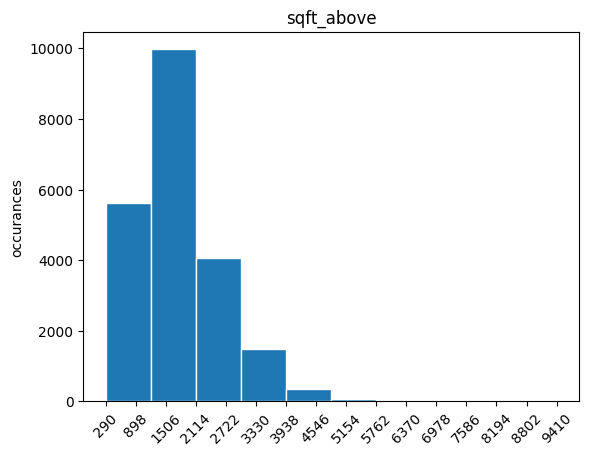

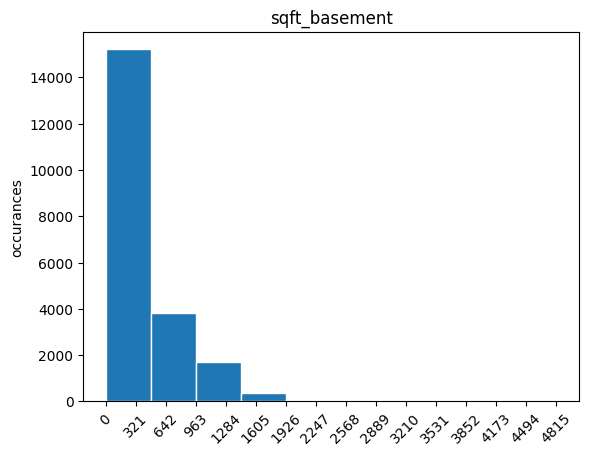

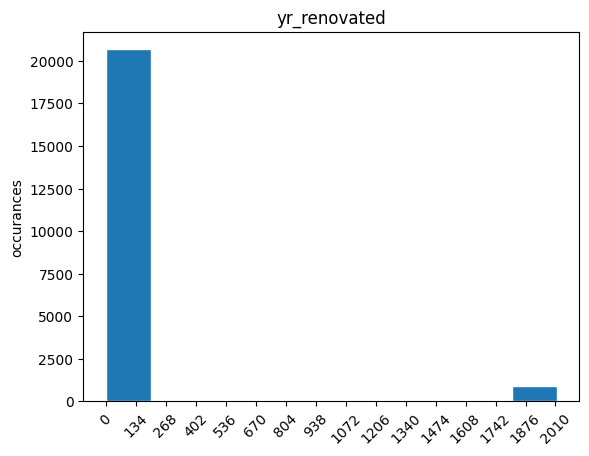

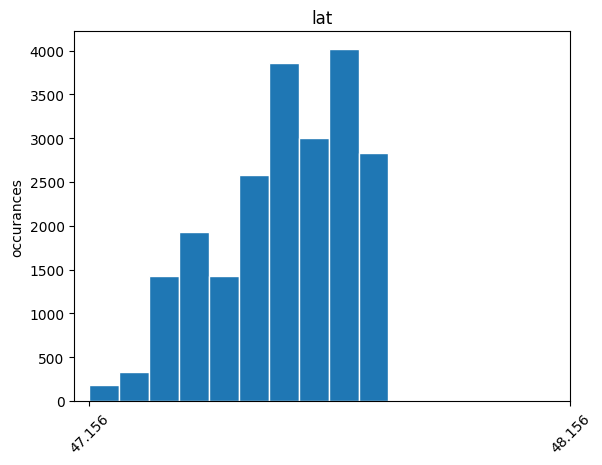

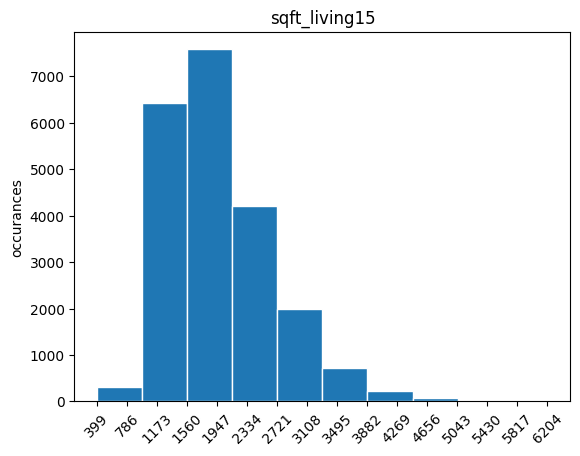

In [28]:
for feature in high_corr.index:
    plt.hist(data[feature], edgecolor='white')
    tick = (data[feature].max() - data[feature].min()) // 15
    tick = tick if tick > 0 else 1
    plt.xticks(np.arange(data[feature].min(), data[feature].max() + 1, tick), rotation = 45)
    plt.ylabel('occurances')
    plt.title(feature)
    plt.show()

## 1.7 Handle Missing Values

we don't have missing for categorical features, so we use `median` method to fill them, some of methods are:

- `fillna()`: This method is used to fill missing values with a specified value or method. For example, you can fill missing values with a constant value like 0 or a method like forward fill or backward fill.

- `dropna()`: This method is used to remove rows or columns that contain missing values. This can be useful if you have a large dataset and only a small percentage of the data is missing.

- `interpolate()`: This method is used to fill missing values with interpolated values. Interpolation is a method of estimating missing values based on the values of neighboring data points.

- `Imputation`: This method involves using statistical methods to estimate missing values based on the values of other variables in the dataset. There are several imputation methods available in pandas, such as `mean` imputation, `median` imputation, and `regression` imputation.


In [29]:
data.select_dtypes(include='object').isna().sum()


date        0
location    0
style       0
dtype: int64

In [30]:
pre.fill_nan()
pre.get_missing()

C:\Users\asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


,missing_count,missing_percentage
date,0,0.0
price,0,0.0
bedrooms,0,0.0
bathrooms,0,0.0
sqft_living,0,0.0
sqft_lot,0,0.0
floors,0,0.0
waterfront,0,0.0
view,0,0.0
condition,0,0.0


## 1.8 Encoding Categorical Values

- `Label Encoding`: This method assigns a unique integer label to each category in the data. This is useful when the categories have an inherent order or ranking, such as low, medium, and high. The LabelEncoder class from the sklearn.preprocessing module can be used to perform label encoding.

- `One-Hot Encoding`: This method creates a binary column for each category in the data, indicating whether the category is present or not. This is useful when the categories do not have an inherent order or ranking, and when the number of categories is small. The get_dummies() function from Pandas can be used to perform one-hot encoding.

- `Binary Encoding`: This method creates binary columns for each category in the data, but instead of using a single binary column for each category, it uses a binary code for each category. This is useful when the number of categories is large, as it reduces the number of columns needed for encoding. The BinaryEncoder class from the category_encoders library can be used to perform binary encoding.

- `Count Encoding`: This method replaces each category in the data with the number of times it appears in the dataset. This is useful when the frequency of each category is important, and when the number of categories is large. The CountEncoder class from the category_encoders library can be used to perform count encoding.

- `Target Encoding`: This method replaces each category in the data with the mean of the target variable for that category. This is useful when the relationship between the categories and the target variable is important, and when the number of categories is large. The TargetEncoder class from the category_encoders library can be used to perform target encoding.


for this case, we choose label encoding

In [31]:
pre.encode_categories()


## 1.9 Data Scaling

`Normalizing`: Normalizing is the process of scaling the values of a column to a range between 0 and 1. This is done by subtracting the minimum value of the column from each value, and then dividing by the range of the column (i.e., the difference between the maximum and minimum values). Normalizing is useful when the absolute values of the data are not important, but the relative values are.

`Standardizing`: Standardizing is the process of scaling the values of a column to have a mean of 0 and a standard deviation of 1. This is done by subtracting the mean of the column from each value, and then dividing by the standard deviation of the column. Standardizing is useful when the absolute values of the data are important, and when the data has a normal distribution.

why do we need them:

- `Different scales`: The features in a DataFrame may have different scales, which can cause some features to dominate the others in the analysis. For example, if one feature has values in the range of 0-1 and another feature has values in the range of 0-1000, the second feature will have a much larger impact on the analysis. Normalizing or standardizing the data can ensure that all features have a similar scale and prevent this issue.

- `Outliers`: Outliers in the data can also have a significant impact on the analysis. Normalizing or standardizing the data can reduce the impact of outliers by scaling the data to a more reasonable range.

- `Algorithm requirements`: Some machine learning algorithms require the data to be normalized or standardized in order to work properly. For example, algorithms that use distance measures, such as k-nearest neighbors or clustering algorithms, can be sensitive to the scale of the data. Normalizing or standardizing the data can ensure that these algorithms work properly.

- `Interpretability`: Normalizing or standardizing the data can make the results of the analysis more interpretable. For example, if the data is standardized to have a mean of 0 and a standard deviation of 1, the coefficients of a linear regression model will represent the change in the response variable for a one standard deviation change in the predictor variable.

In [32]:
pre.normalize(['price'])

## 1.10 Validation Data

Validation in data refers to the process of evaluating the performance of a machine learning model on a dataset that is separate from the training dataset. The purpose of validation is to estimate how well the model will perform on new, unseen data.
There are several types of validation techniques that can be used in machine learning, including:

- `Holdout validation`: This technique involves splitting the dataset into two parts: a training set and a validation set. The model is trained on the training set and evaluated on the validation set. The performance on the validation set is used to estimate the performance on new, unseen data.

- `Cross-validation`: This technique involves splitting the dataset into k-folds, where k is a user-defined parameter. The model is trained on k-1 folds and evaluated on the remaining fold. This process is repeated k times, with each fold used as the validation set once. The performance on the k validation sets is averaged to estimate the performance on new, unseen data.

- `Leave-one-out validation`: This technique involves using all but one data point for training and the remaining data point for validation. This process is repeated for each data point in the dataset. The performance on the validation sets is averaged to estimate the performance on new, unseen data.

We perfer not having validation in this project

## 1.11 Train and Test data

- `The training set` is a subset of the available data that is used to train the machine learning model. The model is trained on the input features (also known as predictors or independent variables) and the corresponding output values (also known as labels or dependent variables) in the training set. The goal of training is to learn a mapping between the input features and the output values, so that the model can make accurate predictions on new, unseen data.

- `The test set` is a subset of the available data that is used to evaluate the performance of the machine learning model. The model is applied to the input features in the test set to make predictions, and the predicted output values are compared to the actual output values in the test set. The performance of the model is then evaluated using various metrics, such as accuracy, precision, recall, F1 score, etc.


I perfer to have 10% test and 90% train data


In [33]:
class Data:
    def __init__(self, data):
        self.data = data
        self.X_train = None
        self.X_test = None
        self.y_train = None 
        self.y_test = None

    def split_for_classification(self, goal):
        splitted = train_test_split(self.data.drop([goal], axis = 1), self.data[goal], test_size = 0.1, random_state=1)
        self.X_train, self.X_test, self.y_train, self.y_test = splitted
        
    def split_for_linearReg(self, x, y):
        splitted = train_test_split(self.data[x], self.data[y], test_size = 0.1, random_state=1)
        self.X_train, self.X_test, self.y_train, self.y_test = splitted



## 2. Linear Regression

Main form of simple linear regression function: 
$$f(x) = \alpha x + \beta$$

here we want to find the intercept($\alpha$) and slope($\beta$) by minimizing the derivation of the RSS function:

- step 1: Compute RSS of the training data  

$$ RSS = \Sigma (y_i - (\hat{\beta} + \hat{\alpha} * x_i) )^2 $$

- step 2: Compute the derivatives of the RSS function in term of $\underline{\alpha}$ and $\underline{\beta}$, and set them equal to 0 to find the desired parameters

$$ \frac{\partial RSS}{\partial \beta} = \Sigma (-f(x_i) + \hat{\beta} + \hat{\alpha} * x_i) = 0$$
$$ \to \hat{\beta} = \hat{y} - \hat{\alpha} \hat{x} \to (1)$$


$$ \frac{\partial RSS}{\partial \alpha} = \Sigma (-2 x_i y_i + 2 \hat{\beta} x_i + 2\hat{\alpha} x_i ^ 2) = 0 \to (2)$$

$$ (1) , (2) \to \hat{\alpha} = \frac{\Sigma{(x_i - \hat{x})(y_i - \hat{y})}}{\Sigma{(x_i - \hat{x})^2}}
$$ 
$$ \hat{\beta} = \hat{y} - \hat{\alpha} \hat{x}$$





- `RMSE`:(Root Mean Squared Error) RMSE measures the average distance between the predicted values and the actual values in a dataset. It is calculated as the square root of the average of the squared differences between the predicted and actual values. RMSE is a measure of the spread of the residuals, which are the differences between the predicted values and the actual values. A lower RMSE indicates that the model is better at predicting the actual values.

- `R2 score`: R2 score measures the proportion of the variance in the dependent variable that is explained by the independent variables. It is calculated as 1 minus the ratio of the residual sum of squares (RSS) to the total sum of squares (TSS). R2 score ranges from 0 to 1, with a higher score indicating a better fit of the model to the data.

- `RSS`:(Residual Sum of Squares) RSS measures the sum of the squared differences between the predicted values and the actual values. It is calculated as the sum of the squared residuals. RSS is a measure of the amount of unexplained variance in the dependent variable.

- `MSE`:(Mean Squared Error) MSE measures the average of the squared differences between the predicted values and the actual values. It is calculated as the average of the squared residuals. MSE is a measure of the spread of the residuals, similar to RMSE.





$$ RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_{i,true} - y_{i,pred})^2}$$

where $y_{i,pred}$ is the predicted value, $y_{i,true} $ is the actual value, and mean is the average over all the samples in the dataset.


AS you might guessed, the RMSE has no bound and it is not easy to find out the percentage of fitting the model into data with it. instead, we use R2 score. The R2 score is calculated by comparing the sum of the squared differences between the actual and predicted values of the dependent variable to the total sum of squared differences between the actual and mean values of the dependent variable. Matematically, the R2 score formula is shown as follows:

$$R^2 = 1 - \frac{SSres}{SStot} = 1 - \frac{\sum_{i=1}^{n} (y_{i,true} - y_{i,pred})^2}{\sum_{i=1}^{n} (y_{i,true} - \bar{y}_{true})^2} $$

In [34]:
class Linear_regression():
    def __init__(self, data):
        self.data = data
        self.intercept = ((self.data.X_train - self.data.X_train.mean()) * (self.data.y_train - self.data.y_train.mean())).sum() / ((self.data.X_train - self.data.X_train.mean())**2).sum()
        self.slope = self.data.y_train.mean() - self.intercept * self.data.X_train.mean()
        self.predicted_values = self.intercept * self.data.X_test + self.slope
        self.RMSE = None
        self.R2 = None

    def get_intercept_slope(self):
        return(self.intercept, self.slope)
    
    def get_predictions(self):
        return(self.predicted_values)
    
    def get_RSME(self):
        n = self.predicted_values.shape[0]
        self.RMSE = math.sqrt(((self.predicted_values - self.data.y_test) ** 2).sum() / n)
        return(self.RMSE)

    def get_RSME_train(self):
        train_predict = self.intercept * self.data.X_train + self.slope
        n = train_predict.shape[0]
        train_RMSE = math.sqrt(((train_predict - self.data.y_train) ** 2).sum() / n)
        return(train_RMSE)

    def get_R2_score(self):
        self.R2 = 1 - (((self.predicted_values - self.data.y_test) ** 2).sum() / ((self.data.y_test - self.data.y_test.mean()) ** 2).sum())
        return(self.R2)

    def get_R2_score_train(self):
        train_predict = self.intercept * self.data.X_train + self.slope
        train_R2 = 1 - (((train_predict - self.data.y_train) ** 2).sum() / ((self.data.y_train - self.data.y_train.mean()) ** 2).sum())
        return(train_R2)
    
    def show_result(self):
        print(feature, ':')
        a, b = self.get_intercept_slope()
        print('RSME =', self.get_RSME())
        print('RSME train =', self.get_RSME_train())
        print('R2 =', self.get_R2_score())
        print('R2 train =', self.get_R2_score_train())
        x = np.linspace(0,1,100)
        y = a * x + b
        plt.plot(x, y, color = 'red')
        plt.scatter(self.data.X_train, self.data.y_train)
        plt.show()


grade :
RSME = 283772.490159647
RSME train = 272471.5039978642
R2 = 0.44933106872655537
R2 train = 0.444963118315149


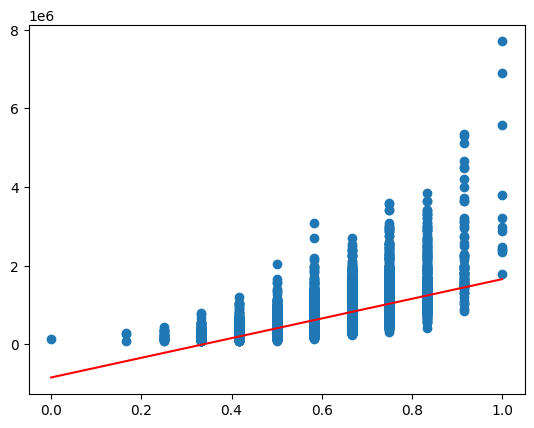

waterfront :
RSME = 365126.504131659
RSME train = 352919.3683256207
R2 = 0.08833200244980388
R2 train = 0.06882640776045879


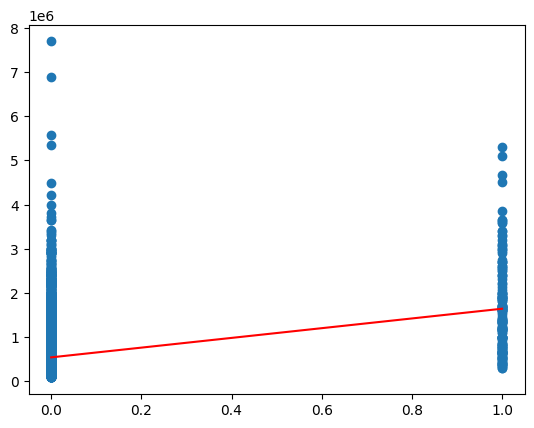

sqft_above :
RSME = 298463.25093247474
RSME train = 291708.01783992443
R2 = 0.3908395173965311
R2 train = 0.36382529506868455


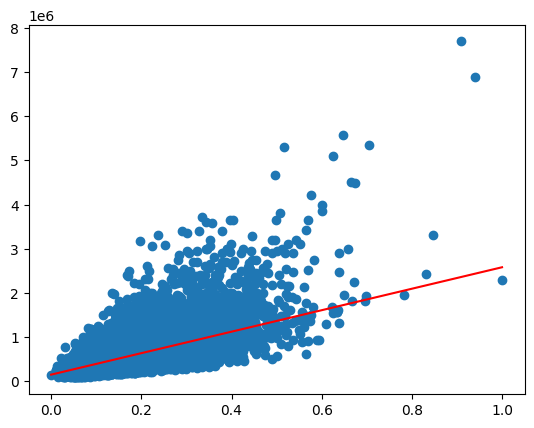

zipcode :
RSME = 381166.2835437676
RSME train = 365297.6568730814
R2 = 0.00647466248601547
R2 train = 0.002360955753783367


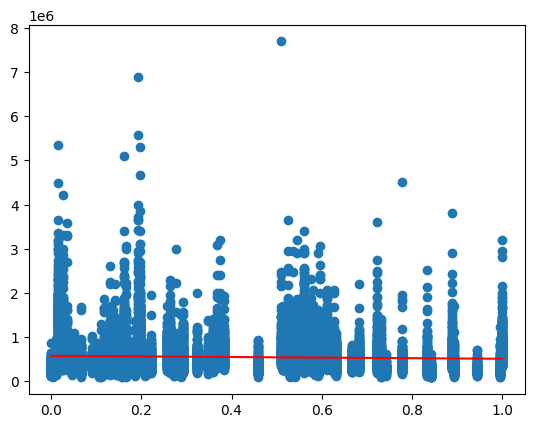

bedrooms :
RSME = 362682.8843835291
RSME train = 348060.26404952374
R2 = 0.10049389806640863
R2 train = 0.09429126718122771


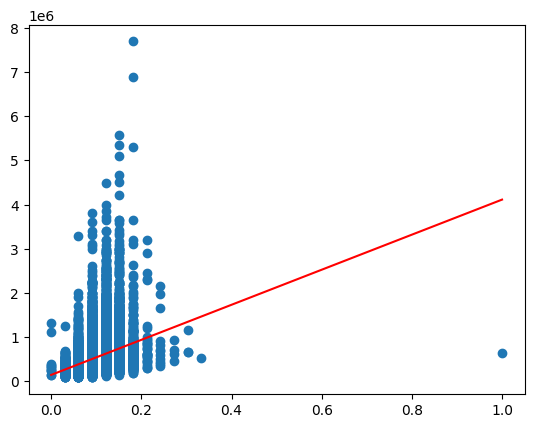

view :
RSME = 350285.38361966575
RSME train = 335732.2708654516
R2 = 0.16093805670742667
R2 train = 0.15731388014651415


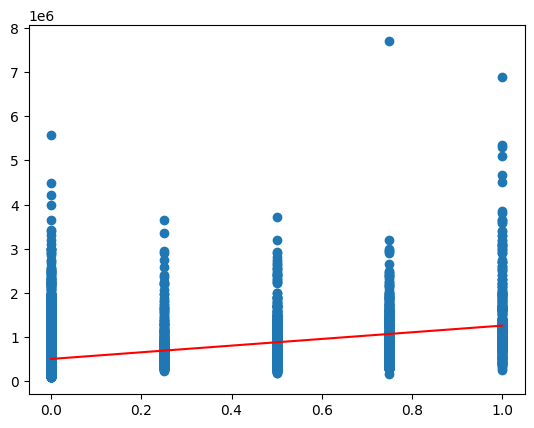

sqft_living15 :
RSME = 306382.32819818176
RSME train = 297003.15826745715
R2 = 0.3580851600442171
R2 train = 0.34051974127423457


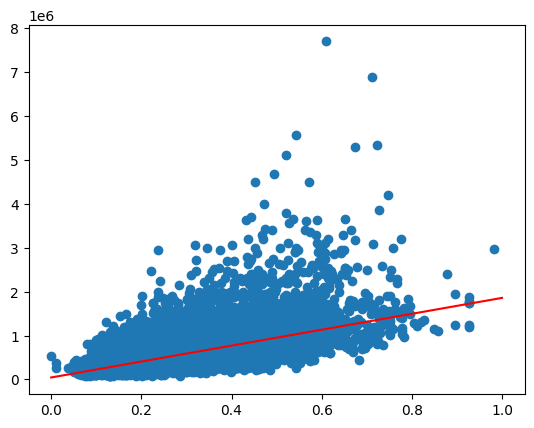

floors :
RSME = 370568.6971833589
RSME train = 355117.1611602548
R2 = 0.060952732823241984
R2 train = 0.057192594662682006


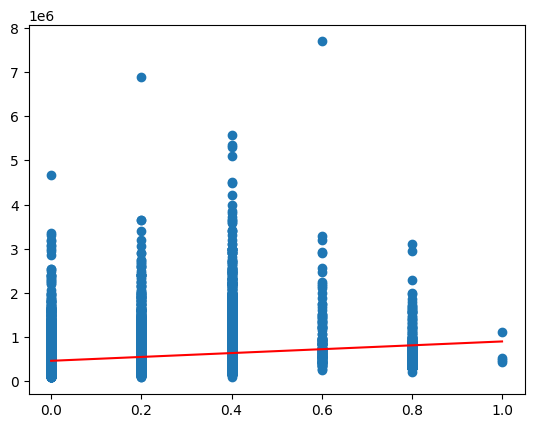

sqft_basement :
RSME = 357242.37584463437
RSME train = 347413.76283228764
R2 = 0.12727798834517856
R2 train = 0.09765274250109757


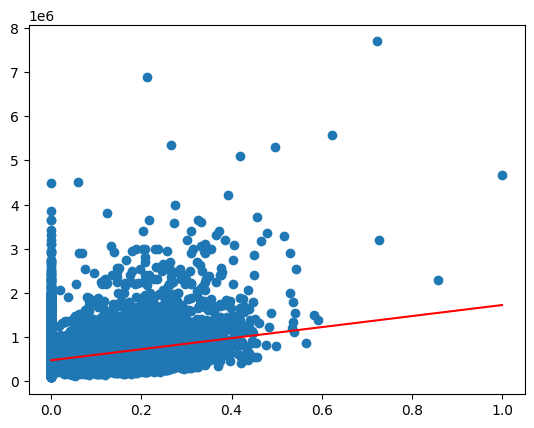

sqft_living :
RSME = 283702.5338734018
RSME train = 277228.51697308646
R2 = 0.44960253975603603
R2 train = 0.4254134337643334


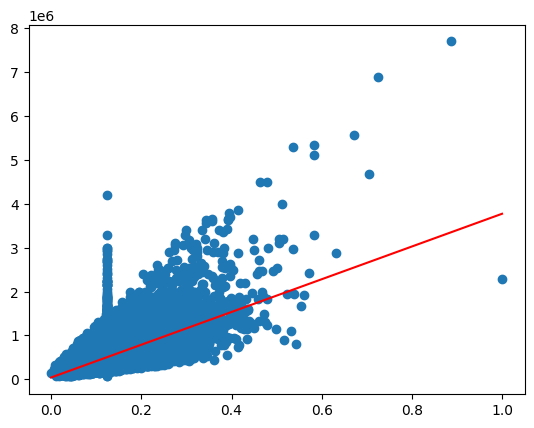

yr_renovated :
RSME = 377970.9932428567
RSME train = 362946.4686832388
R2 = 0.02306215082582863
R2 train = 0.01516196013444615


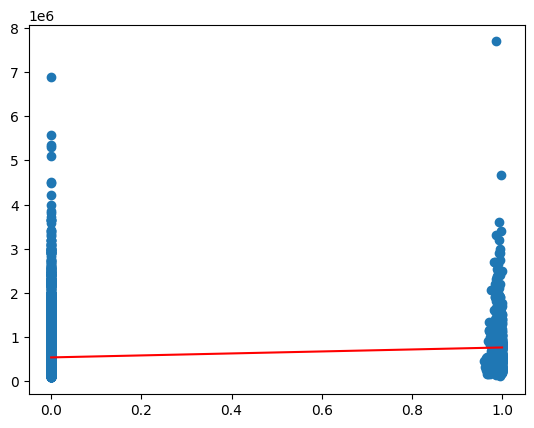

lat :
RSME = 365266.60884628096
RSME train = 347958.354808295
R2 = 0.08763222585742059
R2 train = 0.09482155797800396


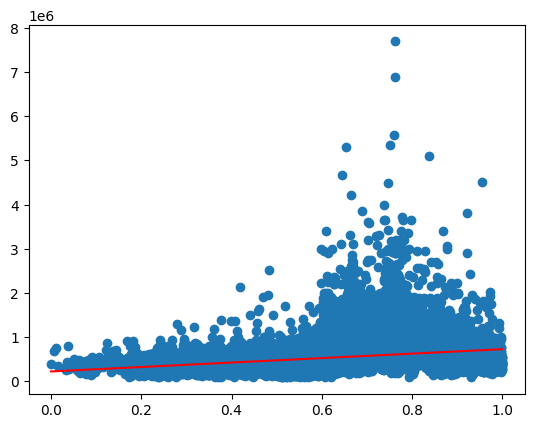

bathrooms :
RSME = 321863.5064143889
RSME train = 311673.5512097188
R2 = 0.2915756697074936
R2 train = 0.27376100681845894


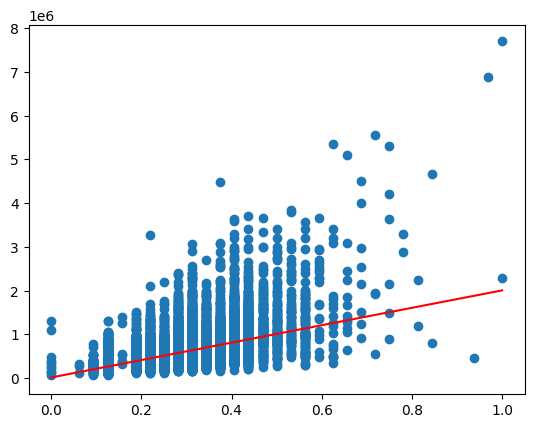

yr_built :
RSME = 381720.1068351897
RSME train = 365296.198921745
R2 = 0.003585439405903723
R2 train = 0.0023689191570400725


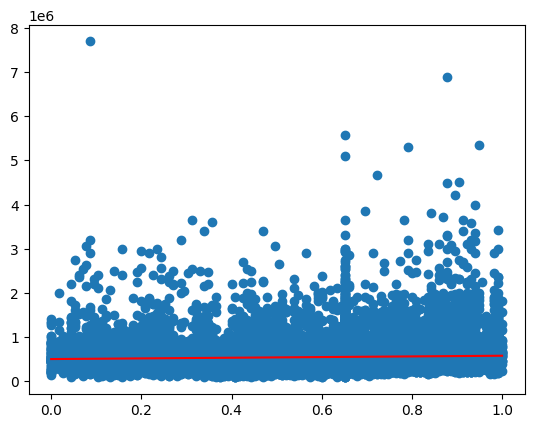

In [35]:
features = set(high_corr.index.to_list() + ['sqft_living' , 'yr_built' , 'grade' , 'zipcode'])
goal = 'price'
prepeared_data = Data(data)

for feature in features:
    prepeared_data.split_for_linearReg(feature, goal)
    reg = Linear_regression(prepeared_data)
    reg.show_result()
    

## 2.1 Analyze

this is a `linear` regression, we can model our learning on a single feature, so blue dots is our data and red line is prediction, according to above statistics and R2 score :
- linear regression is not proper for this case, because of having many effecting variables
- `zipcode` and `yr_built` are completely unlinear
- `sqft_living` and `grade` having slightly linear effect

## 3. Classification

- `Decision Tree`: A decision tree is a type of supervised learning algorithm that is mostly used for classification problems. It works by recursively splitting the data into subsets based on the values of the input features, until a stopping criterion is met. The result is a tree-like structure where each internal node represents a test on an input feature, each branch represents the outcome of the test, and each leaf node represents a class label. Decision trees are easy to interpret and can handle both categorical and numerical data.

- `K-Nearest Neighbor`: K-Nearest Neighbor (KNN) is a type of supervised learning algorithm that is mostly used for classification problems. It works by finding the k nearest neighbors to a given data point in the training set, and assigning the class label that is most common among the k neighbors to the data point. KNN is a non-parametric algorithm, which means that it does not make any assumptions about the underlying distribution of the data. KNN is easy to implement and can handle both categorical and numerical data.

- `Logistic Regression`: Logistic Regression is a type of supervised learning algorithm that is mostly used for classification problems. It works by modeling the probability of a binary outcome (e.g., 0 or 1) as a function of the input features. The output of the logistic regression model is a probability score between 0 and 1, which can be interpreted as the likelihood of the binary outcome. Logistic regression is a parametric algorithm, which means that it makes assumptions about the underlying distribution of the data. Logistic regression is easy to interpret and can handle both categorical and numerical data.

In [36]:
class Classify:
    def __init__(self, data):
        self.data = data
        self.KNearestNeighbor = None
        self.DecisionTree = None
        self.LogisticReg = None
        self.RandomForest = None
        self.XGBoost = None

    
    def create_KNearestNeighbor(self, n_neighbors = 8):
        self.KNearestNeighbor = self._KNN(self.data, n_neighbors)
        return self.KNearestNeighbor

    def create_DecisionTree(self, max_depth=8, min_samples_split=8, min_samples_leaf=2, max_leaf_nodes=None):
        self.DecisionTree = self._DT(self.data, max_depth, min_samples_split, min_samples_leaf, max_leaf_nodes)
        return self.DecisionTree

    def create_LogisticReg(self):
        self.LogisticReg = self._LR(self.data)
        return self.LogisticReg

    def create_RandomForest(self, n_estimators = 10, max_depth = 8, min_samples_split = 5,
                             min_samples_leaf = 2, max_leaf_nodes = None):
        self.RandomForest = self._RF(self.data, n_estimators, max_depth, min_samples_split, min_samples_leaf, max_leaf_nodes)
        return self.RandomForest

    def create_XGBoost(self,learning_rate = 0.1, max_depth = 8, n_estimators = 20):
        self.XGBoost = self._XGB(self.data, learning_rate, max_depth, n_estimators)
        return self.XGBoost

    class _KNN:
        def __init__(self, data, n_neighbors):
            self.data = deepcopy(data)
            self.n_neighbors = n_neighbors

            self.knn = KNeighborsClassifier(n_neighbors = self.n_neighbors)
            self.knn.fit(self.data.X_train, self.data.y_train)
            self.predict = self.knn.predict(self.data.X_test)

        def accuracy(self):
            return metrics.accuracy_score(self.data.y_test, self.predict)

        def train_accuracy(self):
            train_predict = self.knn.predict(self.data.X_train)
            return metrics.accuracy_score(self.data.y_train, train_predict)

        def confusion_matrix(self):
            matrix_knear = metrics.confusion_matrix(self.data.y_test, self.predict)
            matrix_disp = metrics.ConfusionMatrixDisplay(matrix_knear)
            matrix_disp.plot(cmap='Blues')
            plt.title('K Nearest Neighbors Confusion Matrix')
            plt.show()

        def grid_search(self):
            variables_diverse = {
                'n_neighbors': range(1, 20)
            }
            grid = GridSearchCV(self.knn, variables_diverse, scoring='accuracy', n_jobs=2)
            grid.fit(self.data.X_train, self.data.y_train)
            score = grid.score(self.data.X_test, self.data.y_test)
            return score, grid



    class _DT:
        def __init__(self, data, max_depth, min_samples_split, min_samples_leaf, max_leaf_nodes):
            self.data = deepcopy(data)
       
            self.dt = DecisionTreeClassifier(criterion='entropy', max_depth = max_depth, min_samples_split = min_samples_split,
                                             min_samples_leaf = min_samples_leaf, max_leaf_nodes = max_leaf_nodes, random_state = 1)
            self.dt.fit(self.data.X_train, self.data.y_train)
            self.predict = self.dt.predict(self.data.X_test)

        def accuracy(self):
            return metrics.accuracy_score(self.data.y_test, self.predict)

        def train_accuracy(self):
            train_predict = self.dt.predict(self.data.X_train)
            return metrics.accuracy_score(self.data.y_train, train_predict)

        def confusion_matrix(self):
            matrix = metrics.confusion_matrix(self.data.y_test, self.predict)
            display_matrix = metrics.ConfusionMatrixDisplay(matrix)
            display_matrix.plot(cmap='Blues')
            plt.title('Decision Tree Confusion Matrix')
            plt.show()

        def grid_search(self):
            variables_diverse = {
                'criterion': ['entropy'],
                'max_depth': range(2, 10),
                'min_samples_split': range(2, 10),
                'min_samples_leaf': range(1, 5),
                'random_state': [1]
            }
            grid = GridSearchCV(self.dt, variables_diverse, scoring='accuracy', n_jobs=2)
            grid.fit(self.data.X_train, self.data.y_train)
            score = grid.score(self.data.X_test, self.data.y_test)
            return score, grid



    class _LR:
        def __init__(self, data):
            self.data = deepcopy(data) 

            self.logreg = LogisticRegression(random_state = 1, solver='lbfgs', max_iter=1000)
            self.logreg.fit(self.data.X_train, self.data.y_train)
            self.predict = self.logreg.predict(self.data.X_test)

        def accuracy(self):
            return metrics.accuracy_score(self.data.y_test, self.predict)

        def train_accuracy(self):
            train_predict = self.logreg.predict(self.data.X_train)
            return metrics.accuracy_score(self.data.y_train, train_predict)

        def confusion_matrix(self):
            matrix = metrics.confusion_matrix(self.data.y_test, self.predict)
            display_matrix = metrics.ConfusionMatrixDisplay(matrix)
            display_matrix.plot(cmap='Blues')
            plt.title('Logistic Regression Confusion Matrix')
            plt.show()

        def grid_search(self):
            variables_diverse = {
                'penalty' : ['l1','l2'], 
            }
            grid = GridSearchCV(self.logreg, variables_diverse, scoring='accuracy', n_jobs=2)
            grid.fit(self.data.X_train, self.data.y_train)
            test_score = grid.score(self.data.X_test, self.data.y_test)
            return test_score, grid
 




    class _RF:
        def __init__(self, data, n_estimators, max_depth, min_samples_split, min_samples_leaf, max_leaf_nodes):
            self.data = deepcopy(data)
            self.n_estimators = n_estimators
            self.max_depth = max_depth
 
            self.forest = RandomForestClassifier(criterion='entropy',n_estimators = n_estimators, max_depth = max_depth,
                                                 min_samples_split = min_samples_split, min_samples_leaf = min_samples_leaf,
                                                 max_leaf_nodes = max_leaf_nodes, random_state = 1)
                                                 
            self.forest.fit(self.data.X_train, self.data.y_train)
            self.predict = self.forest.predict(self.data.X_test)

        def accuracy(self):
            return metrics.accuracy_score(self.data.y_test, self.predict)

        def accuracy_train(self):
            train_predict = self.forest.predict(self.data.X_train)
            return metrics.accuracy_score(self.data.y_train, train_predict)

        def confusion_matrix(self):
            matrix = metrics.confusion_matrix(self.data.y_test, self.predict)
            display_matrix = metrics.ConfusionMatrixDisplay(matrix)
            display_matrix.plot(cmap='Blues')
            plt.title('Random Forest Confusion Matrix')
            plt.show()

        def grid_search(self):
            variables_diverse = {
                'n_estimators': range(1, 20),
                'criterion': ['entropy'],
                'max_depth': range(1, 10),
                'random_state': [1]
            }
            grid = GridSearchCV(self.forest, variables_diverse, scoring='accuracy', n_jobs=2)
            grid.fit(self.data.X_train, self.data.y_train)
            test_score = grid.score(self.data.X_test, self.data.y_test)
            return test_score, grid
    

    class _XGB:
        def __init__ (self, data, learning_rate, max_depth, n_estimators):
            self.data = deepcopy(data)
            self.data.y_train = LabelEncoder().fit_transform(self.data.y_train)
            self.data.y_test = LabelEncoder().fit_transform(self.data.y_test)
            self.model = xgboost.XGBClassifier(learning_rate = learning_rate, max_depth = max_depth, n_estimators = n_estimators)
            self.model.fit(self.data.X_train, self.data.y_train)
            self.predict = self.model.predict(self.data.X_test)


        def accuracy(self):
            return metrics.accuracy_score(self.data.y_test, self.predict)

        def accuracy_train(self):
            train_predict = self.model.predict(self.data.X_train)
            return metrics.accuracy_score(self.data.y_train, train_predict)

        def confusion_matrix(self):
            matrix = metrics.confusion_matrix(self.data.y_test, self.predict)
            display_matrix = metrics.ConfusionMatrixDisplay(matrix)
            display_matrix.plot(cmap='Blues')
            plt.title('XGboosting Confusion Matrix')
            plt.show()

        def grid_search(self):
            variables_diverse = {
                'n_estimators': [1, 5, 10],
                'learning_rate': [0.01, 0.1, 0.5],
                'max_depth': [1, 3, 5, 7, 9]
            }
            grid = GridSearchCV(self.model, variables_diverse, scoring='accuracy', n_jobs=2)
            grid.fit(self.data.X_train, self.data.y_train)
            test_score = grid.score(self.data.X_test, self.data.y_test)
            return test_score, grid

## 3.1. Prepearation 

price is goal! but we need a cutoff to `classify` it, because this methods are not numeric but categorical.

so price `median` is a good cutoff to determine `LOW` and `High` price level

In [37]:
data.loc[data['price'] >= data['price'].median(), 'price_level'] = 'HIGH'
data.loc[data['price'] < data['price'].median(), 'price_level'] = 'LOW'

clf_data = data.drop(['price'], axis = 1)

prepeared_data = Data(clf_data)
prepeared_data.split_for_classification('price_level')


## 3.2. Results

- `accuracy`
- `confusion_matrix`

|             |         | **Predicted** | **Results** |
| :---------- | :-----: | :-: | :-: |
|             | *Value* | *0* | *1* |
| **Actual**  | *0*     | TN  | FP  |
| **Results** | *1*     | FN  | TP  |

- **TN** *(True Negative):* The actual result is false, and the model correctly predicted it as false.
- **FP** *(False Positive):* The actual result is false, but the model wrongly predicted it as true.
- **FN** *(False Negative):* The actual result is true, but the model wrongly predicted it as false.
- **TP** *(True Positive):* The actual result is true, and the model correctly predicted it as true.

$$Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$$
$$Precision = \frac{TP}{TP + FP}$$
$$Recall = \frac{TP}{TP + FN}$$


Decision Tree:
accuracy = 0.8744789254284391


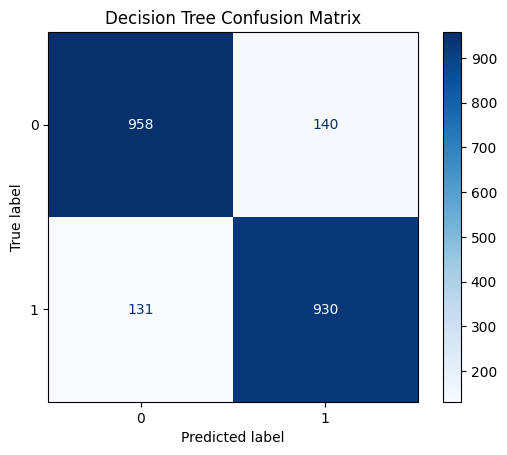

K-Nearest Neighbor:
accuracy = 0.8360352014821677


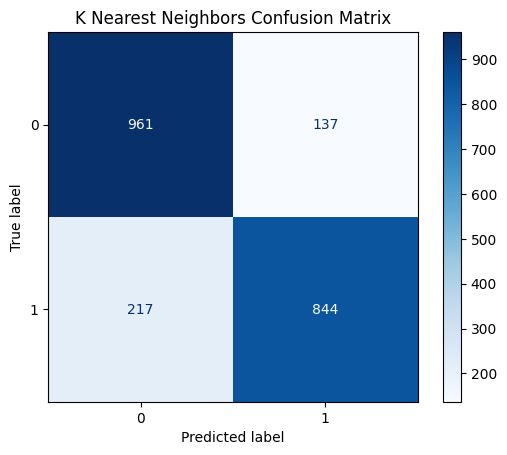

Logistic Regression:
accuracy = 0.8332561371005095


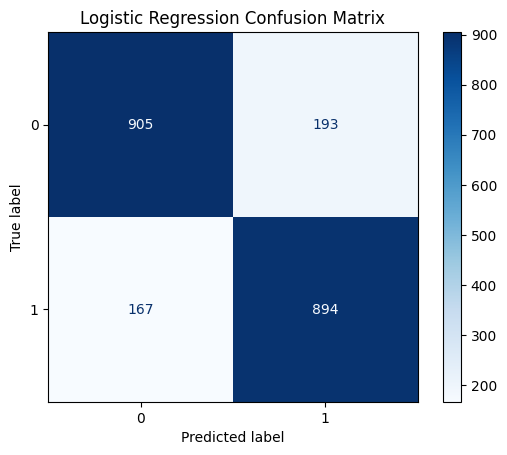

In [38]:
classification = Classify(prepeared_data)


dt = classification.create_DecisionTree()
print("Decision Tree:")
print('accuracy =', dt.accuracy())
dt.confusion_matrix()

knn = classification.create_KNearestNeighbor()
print("K-Nearest Neighbor:")
print('accuracy =', knn.accuracy())
knn.confusion_matrix()

lr = classification.create_LogisticReg()
print("Logistic Regression:")
print('accuracy =', lr.accuracy())
lr.confusion_matrix()


## 3.4 Overfitting and Underfitting

- `Overfitting` occurs when a model is too complex and fits the training data too closely. This means that the model has learned the noise in the training data, rather than the underlying patterns, and is not able to generalize well to new, unseen data. Overfitting can occur when the model has too many parameters relative to the amount of training data, or when the model is trained for too many iterations. Overfitting can be detected by evaluating the performance of the model on a separate test set, and comparing it to the performance on the training set. If the performance on the test set is significantly worse than the performance on the training set, then the model is likely overfitting.

- `Underfitting` occurs when a model is too simple and is not able to capture the underlying patterns in the data. This means that the model is not able to fit the training data well, and is not able to generalize well to new, unseen data. Underfitting can occur when the model has too few parameters relative to the complexity of the data, or when the model is trained for too few iterations. Underfitting can be detected by evaluating the performance of the model on the training set, and comparing it to the performance on the test set. If the performance on both the training set and the test set is poor, then the model is likely underfitting.

In [39]:
print("Decision Tree:")
print('test accuracy =', dt.accuracy())
print('train accuracy =', dt.train_accuracy(),'\n')

print("K-Nearest Neighbor:")
print('test accuracy =', knn.accuracy())
print('train accuracy =', knn.train_accuracy(),'\n')

print("Logistic Regression:")
print('test accuracy =', lr.accuracy())
print('train accuracy =', lr.train_accuracy(),'\n')

Decision Tree:
test accuracy = 0.8744789254284391
train accuracy = 0.906011941527692 

K-Nearest Neighbor:
test accuracy = 0.8360352014821677
train accuracy = 0.8724521309450278 

Logistic Regression:
test accuracy = 0.8332561371005095
train accuracy = 0.8414659254683962 



According to results, train and test result are close so there is no underfitting or overfitting, it is because hyperparameters are chosen wisly( after multiple tests :) )

## 3.5 Grid Search

Grid search is a technique used in machine learning to find the optimal hyperparameters for a given model. Hyperparameters are parameters that are not learned from the data, but are set by the user before training the model. Examples of hyperparameters include the learning rate, regularization strength, number of hidden layers

## 3.5.1 Decision Tree 

In [40]:
score, grid = dt.grid_search()
print('best grid test reult =', score)
grid_result = grid.cv_results_
results = pd.DataFrame(grid_result)
results.drop(['mean_fit_time', 'std_fit_time', 'mean_score_time',
'std_score_time','split0_test_score','split1_test_score', 'split2_test_score',
'split3_test_score','split4_test_score','std_test_score', 'params', 'rank_test_score'], axis=1, inplace=True)
results.sort_values('mean_test_score', ascending=False, inplace=True)
results.reset_index(drop=True, inplace=True)
display(results)

best grid test reult = 0.8754052802223251


,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_random_state,mean_test_score
0,entropy,9,2,5,1,0.883879
1,entropy,9,2,8,1,0.883467
2,entropy,9,2,7,1,0.883416
3,entropy,9,2,2,1,0.883416
4,entropy,9,2,3,1,0.883416
...,...,...,...,...,...,...
251,entropy,2,4,6,1,0.772184
252,entropy,2,4,7,1,0.772184
253,entropy,2,4,8,1,0.772184
254,entropy,2,4,9,1,0.772184


## 3.5.2 K-Nearest Neighbor

In [41]:
score, grid = knn.grid_search()
print('best grid test reult =', score)
grid_result = grid.cv_results_
results = pd.DataFrame(grid_result)
results.drop(['mean_fit_time', 'std_fit_time', 'mean_score_time',
'std_score_time','split0_test_score','split1_test_score', 'split2_test_score',
'split3_test_score','split4_test_score','std_test_score', 'params', 'rank_test_score'], axis=1, inplace=True)
results.sort_values('mean_test_score', ascending=False, inplace=True)
results.reset_index(drop=True, inplace=True)
display(results)

best grid test reult = 0.8360352014821677


,param_n_neighbors,mean_test_score
0,15,0.835238
1,14,0.834980
2,13,0.834877
3,16,0.834414
4,17,0.834105
5,19,0.834003
6,18,0.833797
7,7,0.833797
8,12,0.833745
9,11,0.833127


## 3.6 Effects of preprocess
- K-nearest neighbor is strongly depend on normalizing
- useless features reduce accuracy

## 4. Ensemle learning

- `Random forest` is a type of ensemble learning algorithm that is used for both classification and regression problems. It works by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees.

- The random forest algorithm works by randomly selecting a subset of the input features and a subset of the training data for each decision tree. This process is repeated for each decision tree in the forest, resulting in a set of diverse decision trees that are trained on different subsets of the data. The output of the random forest algorithm is the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees.

- The random forest algorithm has several advantages over a single decision tree. First, it is less prone to overfitting than a single decision tree, because the diversity of the decision trees in the forest reduces the risk of learning the noise in the data. Second, it can handle both categorical and numerical data, and can handle missing values and outliers. Third, it can provide estimates of feature importance, which can be used to identify the most important features for the classification or regression problem.

Random Forest:
accuracy = 0.8953219082908754


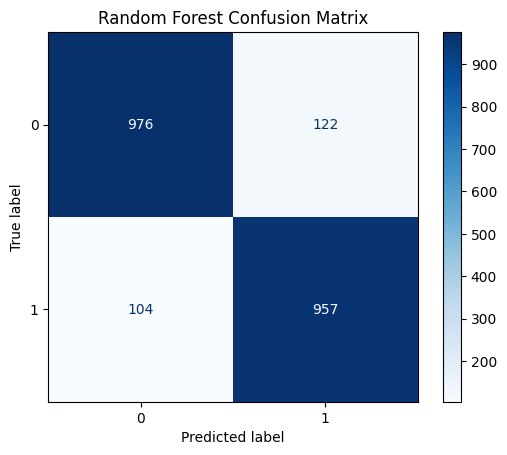

In [42]:
rf = classification.create_RandomForest()
print("Random Forest:")
print('accuracy =', rf.accuracy())
rf.confusion_matrix()

## 4.2. Bias and Variance
- `Bias` refers to the difference between the expected value of the predictions made by a machine learning model and the true values of the target variable. A model with high bias is one that is too simple and is not able to capture the underlying patterns in the data. This means that the model is not able to fit the training data well, and is not able to generalize well to new, unseen data. A model with high bias is said to be underfitting the data.

- `Variance` refers to the variability of the predictions made by a machine learning model for different training sets. A model with high variance is one that is too complex and fits the training data too closely. This means that the model has learned the noise in the training data, rather than the underlying patterns, and is not able to generalize well to new, unseen data. A model with high variance is said to be overfitting the data.

## 4.3. Hyperparameters Effect
- `n_estimators`: The number of trees in the forest. Increasing this parameter can improve the performance of the model, but can also increase the risk of overfitting.

- `max_depth`: The maximum depth of each tree in the forest. Increasing this parameter can improve the performance of the model, but can also increase the risk of overfitting.

- `min_samples_split`: The minimum number of samples required to split an internal node. Increasing this parameter can lead to more conservative tree growth, which can improve the generalization of the model.

- `min_samples_leaf`: The minimum number of samples required to be at a leaf node. Increasing this parameter can lead to more conservative tree growth, which can improve the generalization of the model.


In [43]:
def number_of_DT_effect(val_range):

    accuracy = []
    for i in val_range:
        randforest = classification.create_RandomForest(n_estimators = i)
        accuracy.append(randforest.accuracy())

    plt.plot(val_range, accuracy)
    plt.xlabel('number_of_DT')
    plt.ylabel('Accuracy')
    plt.show()

def max_depth_effects(val_range):

    accuracy = []
    for i in val_range:
        randforest = classification.create_RandomForest(max_depth = i)
        accuracy.append(randforest.accuracy())

    plt.plot(val_range, accuracy)
    plt.xlabel('max_depth')
    plt.ylabel('Accuracy')
    plt.show()

def min_samples_split_effect(val_range):
  
    accuracy = []
    for i in val_range:
        randforest = classification.create_RandomForest(min_samples_split = i)
        accuracy.append(randforest.accuracy())

    plt.plot(val_range, accuracy)
    plt.xlabel('min samples split')
    plt.ylabel('Accuracy')
    plt.show()

def min_samples_leaf_effect(val_range):
  
    accuracy = []
    for i in val_range:
        randforest = classification.create_RandomForest(min_samples_leaf = i)
        accuracy.append(randforest.accuracy())

    plt.plot(val_range, accuracy)
    plt.xlabel('min samples leaf')
    plt.ylabel('Accuracy')
    plt.show()

def max_leaf_nodes_effect(val_range):
  
    accuracy = []
    for i in val_range:
        randforest = classification.create_RandomForest(max_leaf_nodes = i)
        accuracy.append(randforest.accuracy())

    plt.plot(val_range, accuracy)
    plt.xlabel('max leaf nodes')
    plt.ylabel('Accuracy')
    plt.show()

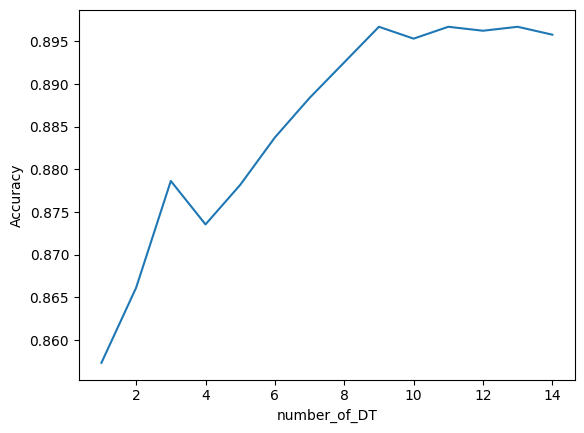

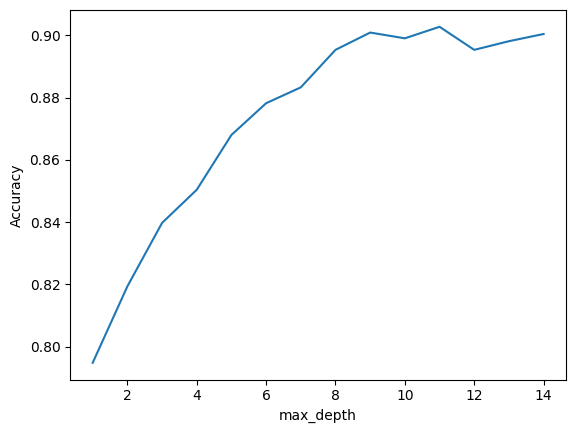

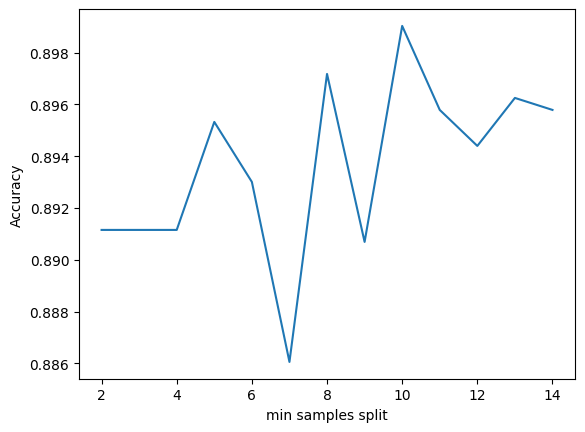

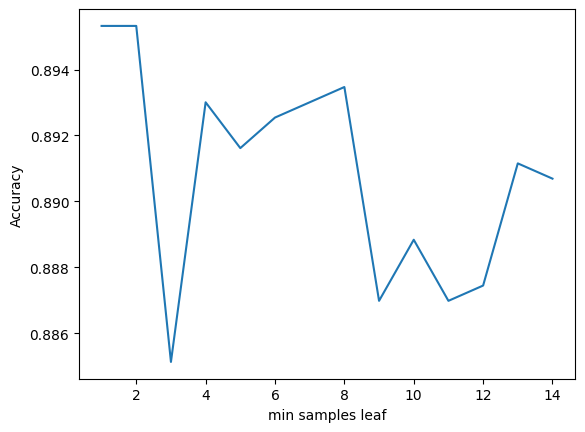

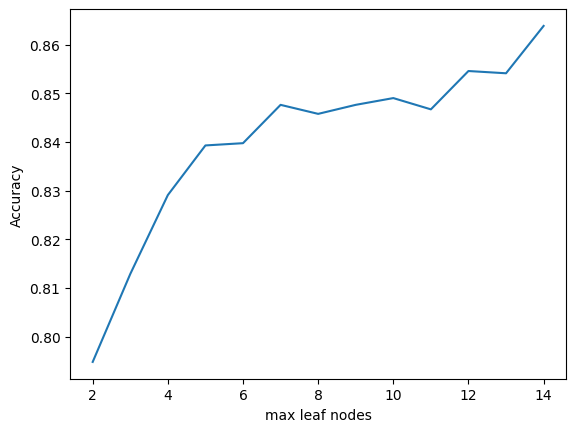

In [44]:
number_of_DT_effect(range(1,15))
max_depth_effects(range(1,15))
min_samples_split_effect(range(2,15))
min_samples_leaf_effect(range(1,15))
max_leaf_nodes_effect(range(2,15))

## 5. X-Gradient Boosting

- The `gradient boosting` algorithm works by iteratively adding decision trees to the ensemble, with each new tree attempting to correct the errors of the previous trees. The algorithm starts by fitting a simple model (e.g., a decision tree) to the data, and then calculates the residuals (i.e., the difference between the predicted values and the true values) of the model. The next model is then trained on the residuals of the previous model, with the goal of reducing the residuals and improving the overall performance of the ensemble. This process is repeated for a fixed number of iterations, or until the performance on the validation set stops improving.


- The gradient boosting algorithm uses a technique called gradient descent to optimize the parameters of the weak learners. Gradient descent is an iterative optimization algorithm that works by computing the gradient of the loss function with respect to the parameters, and then updating the parameters in the direction of the negative gradient. This process is repeated until the loss function reaches a minimum

XGBoosting:
accuracy = 0.9013432144511347


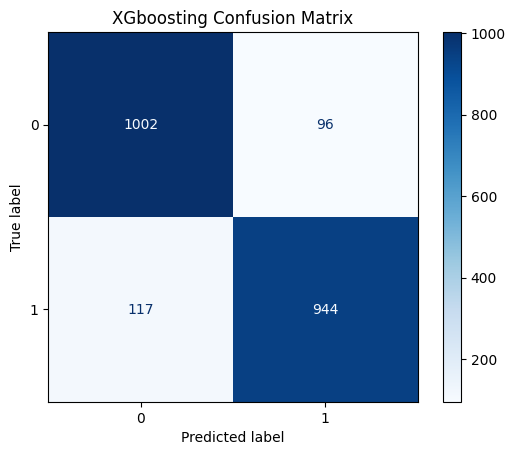

In [45]:
xgb = classification.create_XGBoost()
print("XGBoosting:")
print('accuracy =', xgb.accuracy())
xgb.confusion_matrix()

## 5.1 Grid Search

- `n_estimators`: The number of trees in the ensemble. Increasing this parameter can improve the performance of the model, but can also increase the risk of overfitting.

- `learning_rate`: The step size used in the gradient descent algorithm. A smaller learning rate can lead to slower convergence, but can also improve the generalization of the model.

- `max_depth` : The maximum depth of each tree in the ensemble. Increasing this parameter can improve the performance of the model, but can also increase the risk of overfitting.

In [46]:
score, grid = xgb.grid_search()
print('best grid test reult =', score)
grid_result = grid.cv_results_
results = pd.DataFrame(grid_result)
results.drop(['mean_fit_time', 'std_fit_time', 'mean_score_time',
'std_score_time','split0_test_score','split1_test_score', 'split2_test_score',
'split3_test_score','split4_test_score','std_test_score', 'params', 'rank_test_score'], axis=1, inplace=True)
results.sort_values('mean_test_score', ascending=False, inplace=True)
results.reset_index(drop=True, inplace=True)
display(results)

best grid test reult = 0.905048633626679


,param_learning_rate,param_max_depth,param_n_estimators,mean_test_score
0,0.5,9,10,0.910078
1,0.5,7,10,0.907711
2,0.5,5,10,0.904004
3,0.5,9,5,0.903233
4,0.5,7,5,0.902872
5,0.1,9,10,0.901225
6,0.1,7,10,0.898857
7,0.1,9,5,0.897313
8,0.5,5,5,0.892166
9,0.1,7,5,0.892063


## 5.2 Boosting Tree vs Decision Tree
- `Ensemble vs. Single Model`: Boosting tree is an ensemble learning algorithm that combines multiple weak learners (usually decision trees) into a strong learner, while decision tree is a single model that makes predictions based on a single tree-like structure.

- `Iterative vs. Non-Iterative`: Boosting tree is an iterative algorithm that adds new trees to the ensemble iteratively, with each new tree attempting to correct the errors of the previous trees, while decision tree is a non-iterative algorithm that constructs a single tree-like structure based on the input features.

- `Bias-Variance Tradeoff`: Boosting tree is designed to reduce both bias and variance, by combining multiple weak learners into a strong learner that can make accurate predictions on new, unseen data, while decision tree is prone to overfitting, especially when the tree is too deep or the number of training samples is too small.

- `Hyperparameters`: Boosting tree has several hyperparameters that can be tuned to improve its performance, such as the learning rate, the number of trees in the ensemble, the maximum depth of each tree, and the minimum number of samples required to split a node, while decision tree has fewer hyperparameters, such as the maximum depth of the tree, the minimum number of samples required to split a node, and the splitting criterion.

- `Interpretability`: Decision tree is more interpretable than boosting tree, because it produces a single tree-like structure that can be easily visualized and understood, while boosting tree produces an ensemble of trees that can be more difficult to interpret.